<a href="https://colab.research.google.com/github/abhilasha-kumar/modeling-lexical-retrieval/blob/main/LexicalRetrieval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Allow drive access

In [2]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


# GPU access

In [3]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Found GPU at: /device:GPU:0
Mon Jan 24 02:47:01 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    27W /  70W |    264MiB / 15109MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                            

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import heapq
import itertools
import scipy.spatial.distance

import pandas as pd
import numpy as np

from numpy.random import randint
from scipy.special import softmax
from sklearn.preprocessing import MinMaxScaler, normalize
from numpy.linalg import matrix_power
from functools import lru_cache
import glob
from scipy.special import expit
from scipy import stats

import matplotlib.pyplot as plt
import nltk
from functools import lru_cache
from itertools import product as iterprod
import itertools
from nltk.metrics import *
import re
import math
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Importing Data

In [4]:
with tf.device('/device:GPU:0'):
  julie_files = pd.read_csv("/content/drive/My Drive/LexicalRetrieval-2021/scripts data/Julie_2021data.csv", encoding= 'unicode_escape')
  orig_vocab = pd.read_csv("/content/drive/My Drive/LexicalRetrieval-2021/scripts data/julie_vocab.csv")
  vocab_plus = pd.read_csv("/content/drive/My Drive/LexicalRetrieval-2021/scripts data/full_vocab.csv")

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (23) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Import USE

The Universal Sentence Encoder uses two different architctures to encode a string of any length into a compact high-dimensional vector representation -- the Deep Averaging Network (which is more of a bag-of-words approach) and the Transformer network (more predictive, attention-based). See link above for more details -- but DAN is generally faster and slightly less accurate than the Transformer model on NLP tasks (we might want to compare both). Below we see some examples of how we can use these "vectors" to find "closest neighbors"

In [5]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
dan_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
#transformer_url = "https://tfhub.dev/google/universal-sentence-encoder-large/5" 
model = hub.load(dan_url)
print ("module %s loaded" % dan_url)

module https://tfhub.dev/google/universal-sentence-encoder/4 loaded


In [5]:
# cosine similarity function
def cosine(u, v):
    return np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v))

In [26]:
sent1 = "Capital of Finland"
print("prompt is:", sent1)
sent1_vec = model([sent1])[0]
print("sent1_vec is a numpy array of shape:", sent1_vec.shape)
resp = list(vocab.vocab_word)
print(f"our vocab has {len(resp)} words from which we will find the ones closest to our sentence...")
cosine_list = [cosine(sent1_vec, model([r])[0]) for r in resp]
vocab["cosine"] = cosine_list
vocab.nlargest(10, "cosine")

prompt is: Capital of Finland
sent1_vec is a numpy array of shape: (512,)
our vocab has 13692 words from which we will find the ones closest to our sentence...


KeyboardInterrupt: ignored

In [ ]:
sent1 = "Last name of author of Little Women"
print("prompt is:", sent1)
sent1_vec = model([sent1])[0]
print("sent1_vec is a numpy array of shape:", sent1_vec.shape)
resp = list(vocab.vocab_word)
print(f"our vocab has {len(resp)} words from which we will find the ones closest to our sentence...")
cosine_list = [cosine(sent1_vec, model([r])[0]) for r in resp]
vocab["cosine"] = cosine_list
vocab.nlargest(10, "cosine")

prompt is: Last name of author of Little Women
sent1_vec is a numpy array of shape: (512,)
our vocab has 12619 words from which we will find the ones closest to our sentence...


,vocab_word,cosine
41,Alcott,0.387014
83,author,0.371520
11085,surname,0.349252
779,Rowling,0.270690
8518,petite,0.231320
780,runt,0.224465
7432,midget,0.220665
1944,biography,0.219154
12544,writer,0.217155
81,Austen,0.214192


In [ ]:
sent1 = "Instrument for performing calculations by sliding beads along rods or grooves"
print("prompt is:", sent1)
sent1_vec = model([sent1])[0]
print("sent1_vec is a numpy array of shape:", sent1_vec.shape)
resp = list(vocab.vocab_word)
print(f"our vocab has {len(resp)} words from which we will find the ones closest to our sentence...")
cosine_list = [cosine(sent1_vec, model([r])[0]) for r in resp]
vocab["cosine"] = cosine_list
vocab.nlargest(10, "cosine")

prompt is: Instrument for performing calculations by sliding beads along rods or grooves
sent1_vec is a numpy array of shape: (512,)
our vocab has 12619 words from which we will find the ones closest to our sentence...


,vocab_word,cosine
2,abacus,0.361816
148,calculations,0.336181
2405,calculation,0.305555
6389,instruments,0.305101
399,grooves,0.302247
12417,wind instrument,0.292259
104,beads,0.290021
6388,instrument,0.284906
471,Instrument,0.284906
7695,musical instrument,0.276964


The Transformer based USE model is pretty accurate in and of itself, whereas the DAN is not so accurate. But we want to model a "human" version of this model, so we can add some stochastic noise to these estimates for both models eventually

# Create phoneme function

Here we create a function that takes any letter string and partitions it into phonemes based on arpabet. Then we compute a measure of "normalized" phonemic similarity

In [6]:
# algo to obtain phonemes for any given strng
# obtained from: https://stackoverflow.com/questions/33666557/get-phonemes-from-any-word-in-python-nltk-or-other-modules
try:
    arpabet = nltk.corpus.cmudict.dict()
except LookupError:
    nltk.download('cmudict')
    arpabet = nltk.corpus.cmudict.dict()

@lru_cache()
def wordbreak(s):
    s = s.lower()
    if s in arpabet:
        return arpabet[s]
    middle = len(s)/2
    partition = sorted(list(range(len(s))), key=lambda x: (x-middle)**2-x)
    for i in partition:
        pre, suf = (s[:i], s[i:])
        if pre in arpabet and wordbreak(suf) is not None:
            return [x+y for x,y in iterprod(arpabet[pre], wordbreak(suf))]
    return None

def normalized_sim(w1, w2):
  return 1-edit_distance(w1,w2)/(max(len(w1), len(w2)))

[nltk_data] Downloading package cmudict to /root/nltk_data...
[nltk_data]   Unzipping corpora/cmudict.zip.


In [ ]:
w1 = "bird"
w2 = "burden"
print("wordbreak(w1)[0]:",wordbreak(w1)[0])
print("wordbreak(w2)[0]:",wordbreak(w2)[0])

print("normalized orthographic similarity (letters):", normalized_sim(w1, w2))
print("normalized phonemic similarity:", normalized_sim(wordbreak(w1)[0],wordbreak(w2)[0]))

wordbreak(w1)[0]: ['B', 'ER1', 'D']
wordbreak(w2)[0]: ['B', 'ER1', 'D', 'AH0', 'N']
normalized orthographic similarity (letters): 0.5
normalized phonemic similarity: 0.6


## semantic 

Below we get cosines from the prompt to the different primes and targets in our data

In [ ]:
## get cosines for:
# 1. prompt - target
# 2. prompt - primes
# 3. prompt - resp

both_prompt = []
neither_prompt = []
phon_prompt = []
sem_prompt = []
prime_prompt = []
target_prompt = []
resp_prompt = []

# 4. target- primes
target_both = []
target_neither = []
target_sem = []
target_phon = []
target_prime = []
# 5. target - answer
target_resp = []


for index, row in julie_files.iterrows():
  prompt_vec = model([row["prompt"]])[0]
  target_vec = model([row["Target"]])[0]
  resp = re.sub('[^a-zA-Z]+', '', str(row["Resp"]))
  prime = str(row["Prime"])
  #print("resp =", resp)
  

  both_prompt_sim = cosine(prompt_vec, model([row["Both"]])[0])
  both_prompt.append(both_prompt_sim)

  neither_prompt_sim = cosine(prompt_vec, model([row["Neither"]])[0])
  neither_prompt.append(neither_prompt_sim)

  phon_prompt_sim = cosine(prompt_vec, model([row["Phonological"]])[0])
  phon_prompt.append(phon_prompt_sim)

  sem_prompt_sim = cosine(prompt_vec, model([row["Semantic"]])[0])
  sem_prompt.append(sem_prompt_sim)

  prime_prompt_sim = cosine(prompt_vec, model([prime])[0])
  prime_prompt.append(prime_prompt_sim)

  target_prompt_sim = cosine(prompt_vec, model([row["Target"]])[0])
  target_prompt.append(target_prompt_sim)
  
  resp_prompt_sim = cosine(prompt_vec, model([resp])[0]) if resp != "" else "NA"
  resp_prompt.append(resp_prompt_sim)
  

  #4. target- primes
  target_both_sim = cosine(target_vec, model([row["Both"]])[0])
  target_both.append(target_both_sim)

  target_neither_sim = cosine(target_vec, model([row["Neither"]])[0])
  target_neither.append(target_neither_sim)

  target_sem_sim = cosine(target_vec, model([row["Semantic"]])[0])
  target_sem.append(target_sem_sim)

  target_phon_sim = cosine(target_vec, model([row["Phonological"]])[0])
  target_phon.append(target_phon_sim)

  target_prime_sim = cosine(target_vec, model([prime])[0])
  target_prime.append(target_prime_sim)

  # 5. target - answer
  target_resp_sim = cosine(target_vec, model([resp])[0]) if resp != "" else "NA"
  target_resp.append(target_resp_sim)


julie_files["both_prompt"]  = both_prompt
julie_files["neither_prompt"]  = neither_prompt
julie_files["sem_prompt"]  = sem_prompt
julie_files["phon_prompt"]  = phon_prompt

julie_files["prime_prompt"]  = prime_prompt
julie_files["target_prompt"]  = target_prompt
julie_files["resp_prompt"]  = resp_prompt

julie_files["target_both"]  = target_both
julie_files["target_neither"]  = target_neither
julie_files["target_sem"]  = target_sem
julie_files["target_phon"]  = target_phon
julie_files["target_prime"]  = target_prime
julie_files["target_resp"]  = target_resp





KeyboardInterrupt: ignored

## phon

Below we get estimates of phonemic similarity from the prompt to the different primes and targets in our data

In [ ]:
## get normalized phonemic similarities for:

# 4. target- primes
target_both = []
target_neither = []
target_sem = []
target_phon = []
target_prime = []
# 5. target - answer
target_resp = []


for index, row in julie_files.iterrows():
  
  resp = re.sub('[^a-zA-Z]+', '', str(row["Resp"]))
  semantic = re.sub('[^a-zA-Z]+', '', str(row["Semantic"]))
  phono = re.sub('[^a-zA-Z]+', '', str(row["Phonological"]))
  neither = re.sub('[^a-zA-Z]+', '', str(row["Neither"]))
  both = re.sub('[^a-zA-Z]+', '', str(row["Both"]))
  

  prime = re.sub('[^a-zA-Z]+', '', str(row["Prime"]))
  #print("resp =", resp)
  

  #4. target- primes
  target_both_sim = normalized_sim(wordbreak(row["Target"])[0],wordbreak(both)[0])
  target_both.append(target_both_sim)

  target_neither_sim = normalized_sim(wordbreak(row["Target"])[0],wordbreak(neither)[0])
  target_neither.append(target_neither_sim)

  target_sem_sim = normalized_sim(wordbreak(row["Target"])[0],wordbreak(semantic)[0])
  target_sem.append(target_sem_sim)

  target_phon_sim = normalized_sim(wordbreak(row["Target"])[0],wordbreak(phono)[0])
  target_phon.append(target_phon_sim)

  target_prime_sim = normalized_sim(wordbreak(row["Target"])[0],wordbreak(prime)[0])
  target_prime.append(target_prime_sim)

  # 5. target - answer
  target_resp_sim = normalized_sim(wordbreak(row["Target"])[0],wordbreak(resp)[0]) if resp != "" else "NA"
  target_resp.append(target_resp_sim)

julie_files["lev_target_both"]  = target_both
julie_files["lev_target_neither"]  = target_neither
julie_files["lev_target_sem"]  = target_sem
julie_files["lev_target_phon"]  = target_phon
julie_files["lev_target_prime"]  = target_prime
julie_files["lev_target_resp"]  = target_resp





In [ ]:
julie_files.to_csv("/content/drive/My Drive/LexicalRetrieval-2021/Julie_2021data.csv")

# preparing/reducing data size

In [8]:
## preparing data
julie_files["ActualPrime"] = np.where(julie_files['PrimeCondition'] == 'P', julie_files['Phonological'], 
                                      np.where(julie_files['PrimeCondition'] == 'B', julie_files['Both'], 
                                               np.where(julie_files['PrimeCondition'] == 'R', julie_files['Semantic'],julie_files['Neither']))) 
julie_files['prompt'] = julie_files['prompt'].str.replace('\t',' ')                                      
julie_files['prompt'] = julie_files['prompt'].str.strip()
print(f"full dataset is {len(julie_files)} rows")
## for target accuracy we only need 100 (prompts) x 4 (primes)
targetacc_data = julie_files[["ActualPrime", "PrimeCondition", "Target", "prompt"]].drop_duplicates()
for i in [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]: 
  targetacc_data['AddPred' + str(i)] = np.nan
targetacc_data['MultPred'] = np.nan
print(f"target accuracy data is {len(targetacc_data)} rows")
## for response accuracy we need the unique responses for each prompt-prime combination

respacc_data = julie_files[["ActualPrime", "PrimeCondition", "Target", "Resp", "prompt"]].drop_duplicates()
print(f"response accuracy data is {len(respacc_data)} rows")

full dataset is 17400 rows
target accuracy data is 400 rows
response accuracy data is 4216 rows


In [9]:
## we reshape the data so that we can run the functions at the "prompt" level
respacc_data = respacc_data.sort_values(by=['prompt'])
resp_wide = respacc_data.pivot(index = ["prompt", "Target", "Resp"], columns = ["PrimeCondition"], values = ["ActualPrime"])
resp_wide = resp_wide.reset_index()
resp_wide.columns = resp_wide.columns.map('|'.join).str.strip('|')
resp_wide = resp_wide[resp_wide.Resp != '12345']
resp_wide = resp_wide.reset_index()
for i in [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]: 
  resp_wide['AddPred' + str(i)] = np.nan
resp_wide['MultPred'] = np.nan
resp_wide

,index,prompt,Target,Resp,ActualPrime|B,ActualPrime|P,ActualPrime|R,ActualPrime|U,AddPred0,AddPred0.1,AddPred0.2,AddPred0.3,AddPred0.4,AddPred0.5,AddPred0.6,AddPred0.7,AddPred0.8,AddPred0.9,AddPred1,MultPred
0,1,20th century American poet whose trademark was...,Cummings,Browning,NaN,NaN,Browning,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,20th century American poet whose trademark was...,Cummings,Carrol,NaN,cummerbund,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,20th century American poet whose trademark was...,Cummings,Cummings,Cunningham,cummerbund,Browning,point,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,20th century American poet whose trademark was...,Cummings,Cunnigham,Cunningham,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,20th century American poet whose trademark was...,Cummings,Dickinson,Cunningham,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2543,2643,Word made by changing the order of letters in ...,anagram,palindrome,acronym,analytic,NaN,chute,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2544,2644,Word made by changing the order of letters in ...,anagram,penumbra,acronym,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2545,2645,Word made by changing the order of letters in ...,anagram,puzzle,NaN,NaN,puzzle,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2546,2646,Word made by changing the order of letters in ...,anagram,synonym,acronym,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Computing all vectors

In [29]:
# pre-computing all vectors for prompts and vocabulary words 
# takes in dataframe containing prompts and vocab list, creates dataframes exports them to Drive
def vectors(data, vocab):
  prompts = pd.Series(data["prompt"].unique())
  p_vecs = np.array([model([x])[0].numpy() for x in prompts])
  print(p_vecs.shape)

  p_vectors_df = pd.DataFrame(p_vecs).transpose()
  print(p_vectors_df.shape)
  p_vectors_df.columns = prompts
  print(p_vectors_df.head())
  p_vectors_df.to_csv("/content/drive/My Drive/LexicalRetrieval-2021/scripts data/PromptVectors_New.csv", index = False)

  words = list(orig_vocab.vocab_word) + list(vocab_plus.vocab_word[12618:]) # original vocab list + all added words from responses
  w_vecs = np.array([model([x])[0].numpy() for x in words])
  print(w_vecs.shape)
  w_vectors_df = pd.DataFrame(w_vecs).transpose()

  print(w_vectors_df.shape)
  w_vectors_df.columns = words
  print(w_vectors_df.head())
  w_vectors_df.to_csv("/content/drive/My Drive/LexicalRetrieval-2021/scripts data/VocabVectors_New.csv", index = False)

vectors(targetacc_data, vocab)


(100, 512)
(512, 100)
   To refrain deliberately and often with an effort of self-denial from an action or practice  ...  Happening by a lucky chance or by accident rather than by design
0                                           0.014262                                           ...                                          -0.002915               
1                                           0.018321                                           ...                                          -0.052756               
2                                           0.026393                                           ...                                          -0.002790               
3                                          -0.029389                                           ...                                           0.019612               
4                                           0.018353                                           ...                                           0.037026    

In [5]:
prompt_vectors = pd.read_csv("/content/drive/My Drive/LexicalRetrieval-2021/scripts data/PromptVectors_New.csv")
print(prompt_vectors.shape)
vocab_vectors = pd.read_csv("/content/drive/My Drive/LexicalRetrieval-2021/scripts data/VocabVectors_New.csv")
print(vocab_vectors.shape)

(512, 100)
(512, 13693)


In [ ]:
# each prompt/vocabulary word is represented by a 512-dimensional vector
prompt_vectors['Capital of South Korea']

0      0.018930
1     -0.011326
2      0.000773
3      0.041382
4     -0.006024
         ...   
507   -0.052603
508    0.031974
509   -0.059387
510   -0.077468
511   -0.072401
Name: Capital of South Korea, Length: 512, dtype: float64

# Model functions

In [8]:
def initial_activation(vocab_words):
  # returns an array of initial activations, currently zero, but eventually replace by word frequency
  x = np.zeros((len(vocab_words),1)).T
  return x

In [9]:
def activate_prompt_neighbors(activations, prompt, noise_level):
  ## takes in a 1-d array of current activations
  ## computes a vector representation of the prompt and returns a vector of similarities to each word in vocab + activations
  ## with some noise added to each estimate
  noise = np.random.normal(0, noise_level, 1)
  prompt_vec = prompt_vectors[prompt].values
  resp = vocab_vectors.columns
  cosine_list = np.array([cosine(prompt_vec, vocab_vectors[r].values) for r in resp]) + activations # eventually add noise
  return cosine_list


In [10]:
def activate_prime_neighbors(prime):
  ## returns "primed" activations for both semantic and phonological 
  prime_vec = vocab_vectors[prime].values
  resp = vocab_vectors.columns
  semantic = np.array([cosine(prime_vec, vocab_vectors[r].values) for r in resp]) 
  phon = np.array([normalized_sim(r, prime) for r in resp]).reshape(semantic.shape)
  assert semantic.shape == phon.shape
  return semantic, phon


In [11]:
def combine_semantic_phonological(prompt_act, semantic, phonological, theta=0): 
  # takes in activation arrays for prompt, prime-semantic, and prime phonological and combine with specified operation
  # returns softmax of combined activations
  if theta <= 1:
    wtds = theta * semantic
    wtdp = (1-theta)*phonological
    comb = np.add(wtds, wtdp) + prompt_act
  else:
    comb = np.multiply(semantic, phonological) + prompt_act
  return softmax(comb)


In [12]:
# not necessary for likelihood analysis
def generate_predictions(activations, topn = 10):
  ## takes in final activations and generates the top10 predictions
  words = list(orig_vocab.vocab_word) + list(vocab_plus.vocab_word[12618:])
  return [words[i] for i in np.argpartition(-activations, topn).flatten().tolist()[:topn]]

#generate_predictions(final_activations, vocab, topn = 10)

In [38]:
i = initial_activation(list(orig_vocab.vocab_word) + list(vocab_plus.vocab_word[12618:]))
x = activate_prompt_neighbors(i, "To goad or push forward; to incite someone to do something, especially something bad", 0.1)
y, z = activate_prime_neighbors('initiate')
#j = vocab_vectors.columns.get_loc('banal')
#print(softmax(x)[0][j])
#print(combine_semantic_phonological(x, y, z, 1.1)[0][j])
print(generate_predictions(softmax(x)))
print(generate_predictions(softmax(y)))
print("neigh", generate_predictions(softmax(z)))
print(generate_predictions(combine_semantic_phonological(x, y, z, 0)))
print(generate_predictions(combine_semantic_phonological(x, y, z, 1)))
print(generate_predictions(combine_semantic_phonological(x, y, z, 0.5)))
print(generate_predictions(combine_semantic_phonological(x, y, z, 1.1)))

['provoke', 'provocation', 'incite', 'provocative', 'rebuke', 'Encourage', 'antagonize', 'encourage', 'Disobedience', 'snitch']
['initiate', 'begin', 'start', 'pick up', 'commence', 'starting', 'engage', 'carry out', 'gather', 'launch']
neigh ['inanimate', 'initiate', 'imitate', 'intimate', 'initial', 'infuriate', 'intimidate', 'instigate', 'intricate', 'insinuate']
['infuriate', 'intimidate', 'imitate', 'instigate', 'agitate', 'initiate', 'incite', 'intimate', 'insinuate', 'irritate']
['encourage', 'giving in', 'incite', 'initiate', 'provoke', 'instigate', 'Encourage', 'provocative', 'overthrow', 'push']
['initiate', 'instigate', 'infuriate', 'incite', 'agitate', 'hesitate', 'motivate', 'imitate', 'incentive', 'intent']
['incite', 'motivate', 'incentive', 'infuriate', 'imitate', 'agitate', 'instigate', 'initiate', 'hesitate', 'provocative']


# Log-Likelihood


In [6]:
notinvocab = []
for index, row in julie_files.iterrows():
  # no response
  if row['Resp'] != '12345' and row['Resp'] not in vocab_vectors.columns:
    notinvocab.append(row['Resp'])

In [7]:
notinvocab

['omnipo',
 'ge',
 'anthro',
 'omnipo',
 'advoc',
 'binumeral',
 'neoprology',
 'rougewave',
 'obstanant',
 'obstrecian',
 'Caroll',
 'goosling',
 'soeul',
 'goosling']

In [47]:
theta = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.1, 1.2]
# clean data
julie_files['ActualPrime'] = np.where(julie_files['PrimeCondition'] == 'P', julie_files['Phonological'], 
                                      np.where(julie_files['PrimeCondition'] == 'B', julie_files['Both'], 
                                               np.where(julie_files['PrimeCondition'] == 'R', julie_files['Semantic'],julie_files['Neither']))) 
julie_files['prompt'] = julie_files['prompt'].str.replace('\t',' ')                                      
julie_files['prompt'] = julie_files['prompt'].str.strip()

# dictionaries to be turned into dataframes
resp_ll = {'prompt':[], 'prime':[], 'resp':[], 'modelType':[], 'theta':[], 'likelihood':[], 'NLL':[]}
targ_ll = {'prompt':[], 'prime':[], 'targ':[], 'modelType':[], 'theta':[], 'likelihood':[], 'NLL': []}
# dictionaries to save prompt and prime activations to avoid running the same calculations more than once
prompt_acts = {}
prime_acts = {}
# counting number of responses/targets excluded from the dataframes (non-responses and words not in the vocabulary)
noresp = 0
notinvocab = 0
tomit = 0

# for any trial of data, run each model, and record the likelihoods of the response/target in the above dictionaries
# takes in a row (trial) from the data, whether to analyze the response or target, and list of theta values representing each model 
def get_likelihoods(row, rort, theta):
  word = row['Resp'] if rort == 'r' else row['Target'] # focus on response or target
  dct = resp_ll if rort == 'r' else targ_ll # specifies dictionary in which to save results 

  # check whether prompt activations have already been saved; if not, create them
  if row["prompt"] not in prompt_acts: 
    init = initial_activation(list(orig_vocab.vocab_word) + list(vocab_plus.vocab_word[12618:])) # initial activation
    prompt_neighbors = activate_prompt_neighbors(init, row["prompt"], 0.1) # activate prompt's neighbors
    prompt_acts[row["prompt"]] = prompt_neighbors # save activations
  else:
    prompt_neighbors = prompt_acts[row["prompt"]] # retrieve saved activations

  i = vocab_vectors.columns.get_loc(word) # get the index of the word in activations lists

  # run each model
  for x in theta:
    # prompt only
    if x==1.2:
      final = softmax(prompt_neighbors)
      mt = 'none'

    # include primes
    else:
      mt = 'mult' if x==1.1 else 'add'

      # check whether prime activations have already been saved; if not, create them
      if row["ActualPrime"] not in prime_acts:
        a, b = activate_prime_neighbors(row["ActualPrime"]) # activate prompt's neighbors
        prime_acts[row["ActualPrime"]] = (a, b) # save activations
      else:
        a, b = prime_acts[row["ActualPrime"]] # retrieve saved activations
      final = combine_semantic_phonological(prompt_neighbors, a, b, x) # combine prompt activations, semantic & phonological prime activations

    # add results to dictionary
    dct['prompt'].append(row['prompt'])
    dct['prime'].append(row['ActualPrime'])
    dct['resp'].append(row['Resp']) if rort=='r' else dct['targ'].append(row['Target'])
    dct['modelType'].append(mt)
    dct['theta'].append(x)
    dct['likelihood'].append(final[0][i])

# go through each row of data
for index, row in julie_files.iterrows():
  # no response
  if row['Resp'] == '12345':
    noresp += 1
  # response not in vocabulary
  elif row['Resp'] not in vocab_vectors.columns:
    notinvocab += 1
  # otherwise, get response likelihood
  else:
    get_likelihoods(row, 'r', theta)
  
  # target not in vocabulary
  if row['Target'] not in vocab_vectors.columns:
    tomit += 1
  # otherwise, get target likelihood
  else:
    get_likelihoods(row, 't', theta)
  
  if index % 100 == 0:
    print("Completed row", index)
    

  

Completed row 0
Completed row 100
Completed row 200
Completed row 300
Completed row 400
Completed row 500
Completed row 600
Completed row 700
Completed row 800
Completed row 900
Completed row 1000
Completed row 1100
Completed row 1200
Completed row 1300
Completed row 1400
Completed row 1500
Completed row 1600
Completed row 1700
Completed row 1800
Completed row 1900
Completed row 2000
Completed row 2100
Completed row 2200
Completed row 2300
Completed row 2400
Completed row 2500
Completed row 2600
Completed row 2700
Completed row 2800
Completed row 2900
Completed row 3000
Completed row 3100
Completed row 3200
Completed row 3300
Completed row 3400
Completed row 3500
Completed row 3600
Completed row 3700
Completed row 3800
Completed row 3900
Completed row 4000
Completed row 4100
Completed row 4200
Completed row 4300
Completed row 4400
Completed row 4500
Completed row 4600
Completed row 4700
Completed row 4800
Completed row 4900
Completed row 5000
Completed row 5100
Completed row 5200
Compl

In [48]:
# calculate negative log-likelihoods
resp_ll['NLL'] = -1 * np.log(resp_ll['likelihood'])
targ_ll['NLL'] = -1 * np.log(targ_ll['likelihood'])


In [49]:
# create dataframes
respLLdf = pd.DataFrame.from_dict(resp_ll)
targLLdf = pd.DataFrame.from_dict(targ_ll)
print(len(julie_files))
print("No response:", noresp)
print("Response not in vocab:", notinvocab)
print(len(respLLdf))

17400
No response: 7537
Response not in vocab: 14
128037


In [50]:
# verify length of data
(17400 - (7537 + 14)) * 13

128037

In [51]:
# number of responses included
17400 - (7537 + 14)

9849

In [53]:
respLLdf.to_csv("/content/drive/My Drive/LexicalRetrieval-2021/scripts data/ResponseLogLikelihoods.csv")
targLLdf.to_csv("/content/drive/My Drive/LexicalRetrieval-2021/scripts data/TargetLogLikelihoods.csv")

In [4]:
respLLdf = pd.read_csv("/content/drive/My Drive/LexicalRetrieval-2021/scripts data/ResponseLogLikelihoods.csv")
targLLdf = pd.read_csv("/content/drive/My Drive/LexicalRetrieval-2021/scripts data/TargetLogLikelihoods.csv")

In [56]:
respLLdf.sort_values(by='likelihood')

,prompt,prime,resp,modelType,theta,likelihood,NLL
6474,Obvious or trite; commonplace,banter,kick,add,0.0,0.000053,9.837030
6475,Obvious or trite; commonplace,banter,kick,add,0.1,0.000054,9.820293
12298,Branch of zoology dealing with birds,bank,Berlin,add,0.0,0.000055,9.811383
6476,Obvious or trite; commonplace,banter,kick,add,0.2,0.000055,9.803813
12299,Branch of zoology dealing with birds,bank,Berlin,add,0.1,0.000056,9.796307
...,...,...,...,...,...,...,...
58019,Last name of Leia's brother and Darth Vader's ...,Kenobi,Kenobi,add,0.0,0.000280,8.180925
53352,Last name of Leia's brother and Darth Vader's ...,Kenobi,Kenobi,add,0.0,0.000280,8.180925
1285,Last name of Leia's brother and Darth Vader's ...,Kenobi,Kenobi,mult,1.1,0.000305,8.094985
53363,Last name of Leia's brother and Darth Vader's ...,Kenobi,Kenobi,mult,1.1,0.000305,8.094985


In [64]:
respLLdf[respLLdf['prime'] != respLLdf['resp']].sort_values(by='likelihood', ascending=False).iloc[100:150]

,prompt,prime,resp,modelType,theta,likelihood,NLL
113797,Last name of man credited with inventing peanu...,Edison,edison,add,0.8,0.000207,8.484817
99821,Last name of first man to sign the Declaration...,Jefferson,jefferson,add,0.7,0.000207,8.484927
13477,Capital of Morocco and famous movie title,Rabat,rabat,add,0.9,0.000207,8.484936
16280,Original last name of Mark Twain,Sawyer,sawyer,add,0.4,0.000206,8.485253
99706,Last name of American transcendentalist known ...,Emerson,emerson,add,0.9,0.000206,8.485439
60679,Tending to talk much or freely; chatty,verbose,chatty verbose,add,0.8,0.000206,8.486768
99820,Last name of first man to sign the Declaration...,Jefferson,jefferson,add,0.6,0.000206,8.488590
26300,Cuban president overthrown by Castro,Bolivar,bolivar,add,0.1,0.000205,8.491788
18942,Cuban president overthrown by Castro,Bolivar,bolivar,add,0.1,0.000205,8.491788
99819,Last name of first man to sign the Declaration...,Jefferson,jefferson,add,0.5,0.000205,8.492399


In [37]:
targLLdf[targLLdf['theta'] == 0.0].drop(columns=['Unnamed: 0']).drop_duplicates().sort_values(by='likelihood', ascending=False).head(50)

,prompt,prime,targ,modelType,theta,likelihood,NLL
3575,Capital of Thailand,Bangalore,Bangkok,add,0.0,0.000197,8.533092
923,Last name of South African imprisoned for 27 y...,Mendel,Mandela,add,0.0,0.000195,8.544402
481,Capital of Venezuela,caravan,Caracas,add,0.0,0.000189,8.576097
1417,The practice of having more than one spouse at...,polygon,polygamy,add,0.0,0.000183,8.604119
3107,The illegal act of writing untrue things about...,label,libel,add,0.0,0.000181,8.619010
143,Having unlimited power; able to do anything,omniscient,omnipotent,add,0.0,0.000179,8.626940
4160,A young goose,goblin,gosling,add,0.0,0.000177,8.640820
4823,Last name of Sherlock Holmes' assistant and fr...,Wilson,Watson,add,0.0,0.000176,8.645683
819,"The complete remains of a dead animal, especia...",canvas,carcass,add,0.0,0.000173,8.660106
4056,Branch of zoology dealing with birds,herpetology,ornithology,add,0.0,0.000173,8.660737


In [67]:
targLLdf.drop_duplicates().sort_values(by='likelihood').head(50)

,prompt,prime,targ,modelType,theta,likelihood,NLL
3507,A habitual spastic motion of particular muscle...,jerk,tic,add,1.0,0.000062,9.696206
3506,A habitual spastic motion of particular muscle...,jerk,tic,add,0.9,0.000062,9.688890
3505,A habitual spastic motion of particular muscle...,jerk,tic,add,0.8,0.000062,9.681769
3504,A habitual spastic motion of particular muscle...,jerk,tic,add,0.7,0.000063,9.674841
3503,A habitual spastic motion of particular muscle...,jerk,tic,add,0.6,0.000063,9.668109
4534,To extend in separate directions from a common...,diva,diverge,add,1.0,0.000064,9.662345
3502,A habitual spastic motion of particular muscle...,jerk,tic,add,0.5,0.000064,9.661571
1365,To cause someone to become perplexed and confused,stupefy,bewilder,add,0.0,0.000064,9.655379
3501,A habitual spastic motion of particular muscle...,jerk,tic,add,0.4,0.000064,9.655230
3500,A habitual spastic motion of particular muscle...,jerk,tic,add,0.3,0.000064,9.649085


In [22]:
targLLdf[targLLdf['targ']=='Skywalker'].drop_duplicates().head(50)

,Unnamed: 0,prompt,prime,targ,modelType,theta,likelihood,tLL
533,533,Last name of Leia's brother and Darth Vader's ...,volt,Skywalker,add,0.0,0.000137,-8.895748
534,534,Last name of Leia's brother and Darth Vader's ...,volt,Skywalker,add,0.1,0.000139,-8.881853
535,535,Last name of Leia's brother and Darth Vader's ...,volt,Skywalker,add,0.2,0.000141,-8.868142
536,536,Last name of Leia's brother and Darth Vader's ...,volt,Skywalker,add,0.3,0.000143,-8.854612
537,537,Last name of Leia's brother and Darth Vader's ...,volt,Skywalker,add,0.4,0.000145,-8.841263
538,538,Last name of Leia's brother and Darth Vader's ...,volt,Skywalker,add,0.5,0.000147,-8.828093
539,539,Last name of Leia's brother and Darth Vader's ...,volt,Skywalker,add,0.6,0.000148,-8.815103
540,540,Last name of Leia's brother and Darth Vader's ...,volt,Skywalker,add,0.7,0.000150,-8.802290
541,541,Last name of Leia's brother and Darth Vader's ...,volt,Skywalker,add,0.8,0.000152,-8.789654
542,542,Last name of Leia's brother and Darth Vader's ...,volt,Skywalker,add,0.9,0.000154,-8.777195


### Range of Likelihood Values

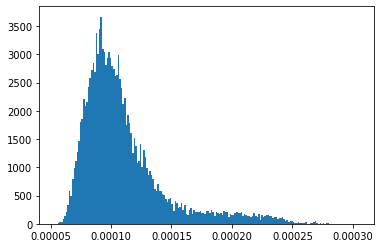

In [54]:
# show distribution and range of response likelihoods 
plt.hist(respLLdf['likelihood'], bins='auto')
plt.show()

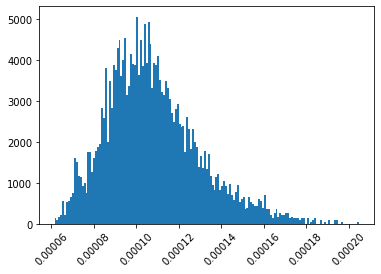

In [55]:
# show distribution and range of target likelihoods 
plt.hist(targLLdf['likelihood'], bins='auto')
plt.xticks(rotation=45)
plt.show()

## Plots and tables

In [5]:
# group by model, sum negative log-likelihoods
rgroup = respLLdf[['theta', 'NLL']].groupby(['theta']).sum()

In [6]:
# group by model, sum negative log-likelihoods
tgroup = targLLdf[['theta', 'NLL']].groupby(['theta']).sum()

In [7]:
rgroup.sort_values(by='NLL', inplace=True) # sum of negative log-likelihoods from lowest (best) to highest

In [10]:
# differences in NLL compared to next worst model
rgroup['deltaNLL'] = rgroup.shift(-1)['NLL'] - rgroup['NLL']
rgroup['deltaNLL'].fillna(0, inplace=True)

In [15]:
tgroup.sort_values(by='NLL', inplace=True)  # sum of negative log-likelihoods from lowest (best) to highest

,NLL,deltaNLL
theta,,
0.0,158775.677577,2273.180966
0.1,158821.368109,2227.490434
0.2,158870.206394,2178.652149
0.3,158922.179761,2126.678782
0.4,158977.275683,2071.582861
0.5,159035.481772,2013.376771
0.6,159096.785782,1952.072762
0.7,159161.175595,1887.682948
0.8,159228.639229,1820.219315


In [12]:
# differences in NLL compared to next worst model
tgroup['deltaNLL'] = tgroup.shift(-1)['NLL'] - tgroup['NLL']
tgroup['deltaNLL'].fillna(0, inplace=True)

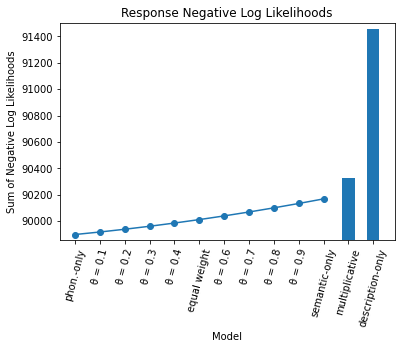

In [19]:
x = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2]
y = rgroup['NLL'] 

# x-axis tick labels
values = ['phon.-only', 'θ = 0.1', 'θ = 0.2', 'θ = 0.3','θ = 0.4','equal weight', 'θ = 0.6', 'θ = 0.7', 'θ = 0.8', 'θ = 0.9', 'semantic-only', 'multiplicative', 'description-only'] 

plt.plot(x[:11],y[:1.0],marker="o") # plot additive models (thetas 0-1) as line plot
plt.bar(x[11:],y[1.1:], width=.05) # plot other models as bar chart
plt.ylim(min(y)-45, max(y)+45) # set y-axis limits
plt.xlabel("Model")
plt.ylabel("Sum of Negative Log Likelihoods")
plt.title("Response Negative Log Likelihoods")
plt.xticks(x,values, rotation=75)
plt.show()

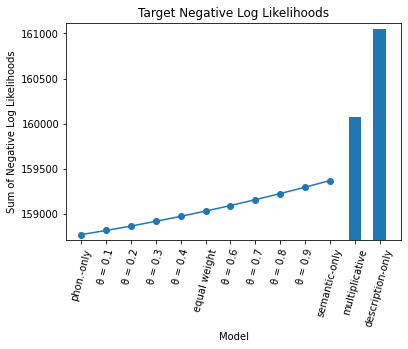

In [20]:

y = tgroup['NLL'] 

# x-axis tick labels
values = ['phon.-only', 'θ = 0.1', 'θ = 0.2', 'θ = 0.3','θ = 0.4','equal weight', 'θ = 0.6', 'θ = 0.7', 'θ = 0.8', 'θ = 0.9', 'semantic-only', 'multiplicative', 'description-only'] 

plt.plot(x[:11],y[:1.0],marker="o") # plot additive models (thetas 0-1) as line plot
plt.bar(x[11:],y[1.1:], width=.05) # plot other models as bar chart
plt.ylim(min(y)-65, max(y)+65) # set y-axis limits
plt.xlabel("Model")
plt.ylabel("Sum of Negative Log Likelihoods")
plt.title("Target Negative Log Likelihoods")
plt.xticks(x,values, rotation=75)
plt.show()

In [13]:
# set k (number of free parameters) for each type of model for BIC calculations
tgroup.loc[ 0:1 , 'k'] = 4
tgroup.loc[1.1 , 'k'] = 3
tgroup.loc[1.2 , 'k'] = 1
rgroup.loc[ 0:1 , 'k'] = 4
rgroup.loc[1.1 , 'k'] = 3
rgroup.loc[1.2 , 'k'] = 1

In [14]:

# create BIC column
tgroup["BIC"] = (tgroup["k"]*math.log(17400)) - (-2*tgroup['NLL'])
rgroup["BIC"] = (rgroup["k"]*math.log(9849)) - (-2*rgroup['NLL']) 

In [15]:
# differences in BIC compared to next worst model
rgroup['deltaBIC'] = rgroup.shift(-1)['BIC'] - rgroup['BIC']
rgroup['deltaBIC'].fillna(0, inplace=True)
tgroup['deltaBIC'] = tgroup.shift(-1)['BIC'] - tgroup['BIC']
tgroup['deltaBIC'].fillna(0, inplace=True)

In [16]:
tgroup.sort_values(by='BIC')

,NLL,deltaNLL,k,BIC,deltaBIC
theta,,,,,
0.0,158775.677577,45.690532,4.0,317590.412056,91.381064
0.1,158821.368109,48.838285,4.0,317681.793120,97.676570
0.2,158870.206394,51.973367,4.0,317779.469690,103.946734
0.3,158922.179761,55.095922,4.0,317883.416424,110.191843
0.4,158977.275683,58.206090,4.0,317993.608267,116.412180
0.5,159035.481772,61.304009,4.0,318110.020447,122.608018
0.6,159096.785782,64.389813,4.0,318232.628465,128.779627
0.7,159161.175595,67.463634,4.0,318361.408092,134.927267
0.8,159228.639229,70.525599,4.0,318496.335359,141.051197


In [21]:
rgroup.sort_values(by='BIC')

,NLL,deltaNLL,k,BIC,deltaBIC
theta,,,,,
0.0,89899.785186,19.054365,4.0,179836.350874,38.108730
0.1,89918.839551,20.834874,4.0,179874.459603,41.669749
0.2,89939.674426,22.608214,4.0,179916.129352,45.216427
0.3,89962.282639,24.374463,4.0,179961.345780,48.748926
0.4,89986.657102,26.133701,4.0,180010.094706,52.267401
0.5,90012.790803,27.886003,4.0,180062.362107,55.772006
0.6,90040.676806,29.631445,4.0,180118.134113,59.262890
0.7,90070.308251,31.370099,4.0,180177.397003,62.740198
0.8,90101.678350,33.102037,4.0,180240.137201,66.204074


In [17]:
rgroup.to_csv("/content/drive/My Drive/LexicalRetrieval-2021/ResponseBIC.csv")
tgroup.to_csv("/content/drive/My Drive/LexicalRetrieval-2021/TargetBIC.csv")

# delta BIC function

In [1]:
def delta(groupdf, n):
  groupdf.loc[ 0:1 , 'k'] = 4
  groupdf.loc[1.1 , 'k'] = 3
  groupdf.loc[1.2 , 'k'] = 1 
  groupdf['BIC'] = (groupdf['k']*math.log(n)) - (-2*groupdf['NLL'])
  groupdf.sort_values(by='BIC', inplace=True)
  groupdf['deltaBIC'] = groupdf.shift(-1)['BIC'] - groupdf['BIC']
  groupdf['deltaBIC'].fillna(0, inplace=True)
  return groupdf

# Error

In [21]:
# response log-likelihood dataframe
respLL = pd.read_csv("/content/drive/My Drive/LexicalRetrieval-2021/scripts data/ResponseLogLikelihoods.csv")

In [22]:
# merge NewAccuracy and prime condition from julie_files
respLL.drop(columns='Unnamed: 0', inplace=True)
respLL.rename(columns = {'resp':'Resp', 'prime': 'ActualPrime'}, inplace=True)
julie_files['ActualPrime'] = np.where(julie_files['PrimeCondition'] == 'P', julie_files['Phonological'], 
                                      np.where(julie_files['PrimeCondition'] == 'B', julie_files['Both'], 
                                               np.where(julie_files['PrimeCondition'] == 'R', julie_files['Semantic'],julie_files['Neither']))) 
julie_files['prompt'] = julie_files['prompt'].str.replace('\t',' ')                                      
julie_files['prompt'] = julie_files['prompt'].str.strip()



In [23]:
newd = respLL.merge(julie_files[['Subject', 'AgeGroup', 'ExperimentName','prompt', 'PrimeCondition', 'ActualPrime','Target', 'Resp', 'NewAccuracy', 'Question.RESP']])

In [25]:
newd.drop_duplicates(inplace=True)
newd.to_csv("/content/drive/My Drive/LexicalRetrieval-2021/scripts data/ResponseLLwithGroups.csv")

In [22]:
newd = pd.read_csv("/content/drive/My Drive/LexicalRetrieval-2021/scripts data/ResponseLLwithGroups.csv")

In [23]:
incorrect = newd[newd['NewAccuracy']==0] # incorrect responses
correct = newd[newd['NewAccuracy']==1] # correct responses
print(len(incorrect))
print(len(correct))

71942
56095


In [30]:
# group by model, sum negative log-likelihoods
incorrg = incorrect[['theta', 'NLL']].groupby(['theta']).sum()
corrg = correct[['theta', 'NLL']].groupby(['theta']).sum()

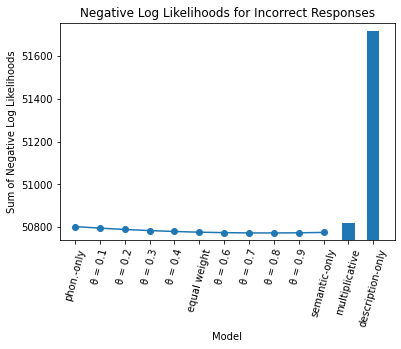

In [25]:
# plot negative log-likelihoods for incorrect responses
x = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2]
y = incorrg['NLL']

values = ['phon.-only', 'θ = 0.1', 'θ = 0.2', 'θ = 0.3','θ = 0.4','equal weight', 'θ = 0.6', 'θ = 0.7', 'θ = 0.8', 'θ = 0.9', 'semantic-only', 'multiplicative', 'description-only'] 

plt.plot(x[:11],y[:1.0],marker="o")
plt.bar(x[11:],y[1.1:], width=.05)
plt.ylim(min(y)-35, max(y)+35)
plt.xlabel("Model")
plt.ylabel("Sum of Negative Log Likelihoods")
plt.title("Negative Log Likelihoods for Incorrect Responses")
plt.xticks(x,values, rotation=75)
plt.show()

In [37]:
delta(incorrg, len(incorrect)/13)

,NLL,k,deltaNLL,BIC,deltaBIC
theta,,,,,
0.8,50773.554051,4.0,0.227138,101581.582766,0.454276
0.7,50773.781189,4.0,0.532012,101582.037042,1.064024
0.9,50774.313201,4.0,0.685052,101583.101066,1.370105
0.6,50774.998253,4.0,1.056787,101584.471171,2.113575
1.0,50776.055040,4.0,1.153883,101586.584746,2.307766
0.5,50777.208924,4.0,3.207999,101588.892512,6.415998
0.4,50780.416922,4.0,4.209093,101595.308509,8.418185
0.3,50784.626015,4.0,5.213996,101603.726695,10.427993
0.2,50789.840011,4.0,6.222755,101614.154688,12.445510


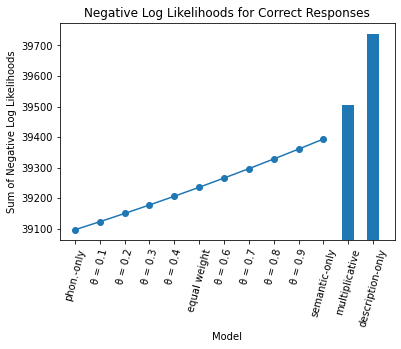

In [32]:
# plot negative log-likelihoods for correct responses
y = corrg['NLL']

values = ['phon.-only', 'θ = 0.1', 'θ = 0.2', 'θ = 0.3','θ = 0.4','equal weight', 'θ = 0.6', 'θ = 0.7', 'θ = 0.8', 'θ = 0.9', 'semantic-only', 'multiplicative', 'description-only'] 

plt.plot(x[:11], y[:1.0] ,marker="o")
plt.bar(x[11:],y[1.1:], width=.05)
plt.ylim(min(y)-35, max(y)+35)
plt.xlabel("Model")
plt.ylabel("Sum of Negative Log Likelihoods")
plt.title("Negative Log Likelihoods for Correct Responses")
plt.xticks(x,values, rotation=75)
plt.show()

In [38]:
delta(corrg, len(correct)/13)

,NLL,k,deltaNLL,BIC,deltaBIC
theta,,,,,
0.0,39096.487004,4.0,26.289780,78226.453419,52.579561
0.1,39122.776785,4.0,27.057630,78279.032980,54.115259
0.2,39149.834414,4.0,27.822210,78333.148239,55.644420
0.3,39177.656624,4.0,28.583556,78388.792659,57.167112
0.4,39206.240180,4.0,29.341700,78445.959771,58.683399
0.5,39235.581880,4.0,30.096673,78504.643170,60.193347
0.6,39265.678553,4.0,30.848509,78564.836517,61.697018
0.7,39296.527062,4.0,31.597237,78626.533535,63.194474
0.8,39328.124299,4.0,32.342887,78689.728009,64.685774


# Prime Condition

In [6]:
# merged dataframe
newd = pd.read_csv("/content/drive/My Drive/LexicalRetrieval-2021/scripts data/ResponseLLwithGroups.csv")

In [17]:
# filter by prime condition
phon = newd[newd['PrimeCondition']=='P']
sem = newd[newd['PrimeCondition']=='R']
both = newd[newd['PrimeCondition']=='B']
neither = newd[newd['PrimeCondition']=='U']
print(len(phon))
print(len(sem))
print(len(both))
print(len(neither))

33592
32955
32877
28613


In [28]:
# group by model, sum negative log-likelihoods
phong = phon[['theta', 'NLL']].groupby(['theta']).sum()
semg = sem[['theta', 'NLL']].groupby(['theta']).sum()
bothg = both[['theta', 'NLL']].groupby(['theta']).sum()
neitherg = neither[['theta', 'NLL']].groupby(['theta']).sum()

## Phonological

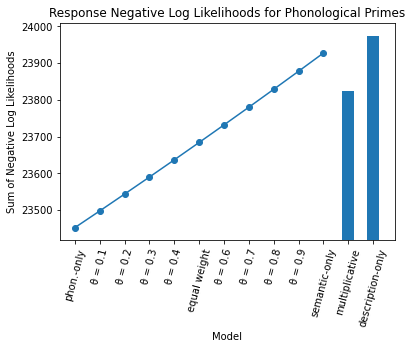

In [9]:
# plot & get tables for response & target negative log-likelihoods for each prime condition

x = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2]
y = phong['NLL']

values = ['phon.-only', 'θ = 0.1', 'θ = 0.2', 'θ = 0.3','θ = 0.4','equal weight', 'θ = 0.6', 'θ = 0.7', 'θ = 0.8', 'θ = 0.9', 'semantic-only', 'multiplicative', 'description-only'] 

plt.plot(x[:11],y[:1.0],marker="o")
plt.bar(x[11:],y[1.1:], width=.05)
plt.ylim(min(y)-35, max(y)+35)
plt.xlabel("Model")
plt.ylabel("Sum of Negative Log Likelihoods")
plt.title("Response Negative Log Likelihoods for Phonological Primes")
plt.xticks(x,values, rotation=75)
plt.show()

In [12]:
delta(phong, len(phon)/13)

,NLL,k,BIC,deltaBIC
theta,,,,
0.0,23452.741789,4.0,46936.911953,90.780640
0.1,23498.132109,4.0,47027.692593,91.718678
0.2,23543.991448,4.0,47119.411271,92.652932
0.3,23590.317914,4.0,47212.064203,93.583444
0.4,23637.109635,4.0,47305.647646,94.510254
0.5,23684.364762,4.0,47400.157900,95.433403
0.6,23732.081464,4.0,47495.591304,96.352930
0.7,23780.257929,4.0,47591.944234,80.259695
1.1,23824.316324,3.0,47672.203929,17.009177


In [38]:
targLL = pd.read_csv("/content/drive/My Drive/LexicalRetrieval-2021/scripts data/TargetLogLikelihoods.csv")
targLL.drop(columns='Unnamed: 0', inplace=True)
targLL.rename(columns = {'targ':'Target', 'prime': 'ActualPrime'}, inplace=True)
julie_files['ActualPrime'] = np.where(julie_files['PrimeCondition'] == 'P', julie_files['Phonological'], 
                                      np.where(julie_files['PrimeCondition'] == 'B', julie_files['Both'], 
                                               np.where(julie_files['PrimeCondition'] == 'R', julie_files['Semantic'],julie_files['Neither']))) 
julie_files['prompt'] = julie_files['prompt'].str.replace('\t',' ')                                      
julie_files['prompt'] = julie_files['prompt'].str.strip()
targ_newd = targLL.merge(julie_files[['prompt', 'PrimeCondition', 'ActualPrime','Target']])

In [40]:
targ_newd.drop_duplicates(inplace=True)
targ_newd.to_csv("/content/drive/My Drive/LexicalRetrieval-2021/scripts data/TargetLLwithGroups.csv")

In [13]:
targ_newd = pd.read_csv("/content/drive/My Drive/LexicalRetrieval-2021/scripts data/TargetLLwithGroups.csv")

In [18]:
tphon = targ_newd[targ_newd['PrimeCondition']=='P']
tsem = targ_newd[targ_newd['PrimeCondition']=='R']
tboth = targ_newd[targ_newd['PrimeCondition']=='B']
tneither = targ_newd[targ_newd['PrimeCondition']=='U']
print(len(tphon))
print(len(tsem))
print(len(tboth))
print(len(tneither))

1300
1300
1300
1300


In [25]:
tphong = tphon[['theta', 'NLL']].groupby(['theta']).sum()
tsemg = tsem[['theta', 'NLL']].groupby(['theta']).sum()
tbothg = tboth[['theta', 'NLL']].groupby(['theta']).sum()
tneitherg = tneither[['theta', 'NLL']].groupby(['theta']).sum()

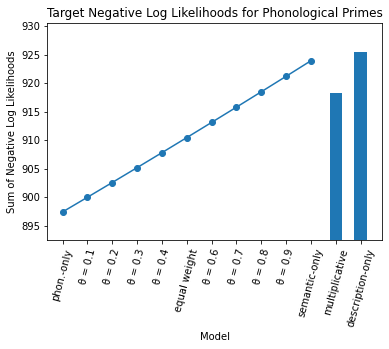

In [46]:
y = tphong['NLL']

values = ['phon.-only', 'θ = 0.1', 'θ = 0.2', 'θ = 0.3','θ = 0.4','equal weight', 'θ = 0.6', 'θ = 0.7', 'θ = 0.8', 'θ = 0.9', 'semantic-only', 'multiplicative', 'description-only'] 

plt.plot(x[:11],y[:1.0],marker="o")
plt.bar(x[11:],y[1.1:], width=.05)
plt.ylim(min(y)-5, max(y)+5)
plt.xlabel("Model")
plt.ylabel("Sum of Negative Log Likelihoods")
plt.title("Target Negative Log Likelihoods for Phonological Primes")
plt.xticks(x,values, rotation=75)
plt.show()

In [20]:
delta(tphong, len(tphon)/13)

,NLL,k,BIC,deltaBIC
theta,,,,
0.0,897.428232,4.0,1813.277146,5.144763
0.1,900.000614,4.0,1818.421909,5.181035
0.2,902.591131,4.0,1823.602943,5.217163
0.3,905.199713,4.0,1828.820107,5.253151
0.4,907.826289,4.0,1834.073258,5.289000
0.5,910.470789,4.0,1839.362258,5.324710
0.6,913.133144,4.0,1844.686969,5.360285
0.7,915.813286,4.0,1850.047253,0.376258
1.1,918.304001,3.0,1850.423512,5.019465


## Semantic

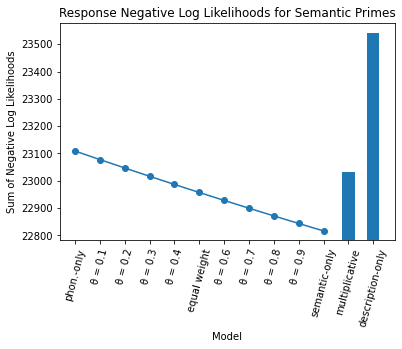

In [29]:
y = semg['NLL']

values = ['phon.-only', 'θ = 0.1', 'θ = 0.2', 'θ = 0.3','θ = 0.4','equal weight', 'θ = 0.6', 'θ = 0.7', 'θ = 0.8', 'θ = 0.9', 'semantic-only', 'multiplicative', 'description-only'] 

plt.plot(x[:11],y[:1.0],marker="o")
plt.bar(x[11:],y[1.1:], width=.05)
plt.ylim(min(y)-35, max(y)+35)
plt.xlabel("Model")
plt.ylabel("Sum of Negative Log Likelihoods")
plt.title("Response Negative Log Likelihoods for Semantic Primes")
plt.xticks(x,values, rotation=75)
plt.show()

In [22]:
delta(semg, len(sem)/13)

,NLL,k,BIC,deltaBIC
theta,,,,
1.0,22816.252783,4.0,45663.857361,54.551406
0.9,22843.528486,4.0,45718.408767,55.424773
0.8,22871.240872,4.0,45773.833540,56.301218
0.7,22899.391481,4.0,45830.134758,57.180772
0.6,22927.981867,4.0,45887.315530,58.063467
0.5,22957.013600,4.0,45945.378996,58.949336
0.4,22986.488268,4.0,46004.328332,59.838414
0.3,23016.407475,4.0,46064.166746,20.398557
1.1,23030.525728,3.0,46084.565303,40.332176


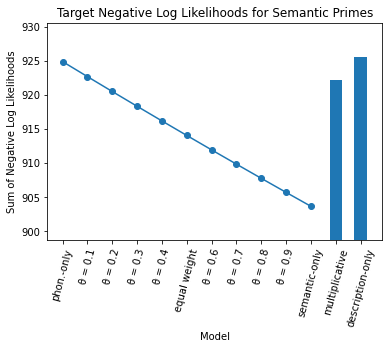

In [26]:
y = tsemg['NLL']

values = ['phon.-only', 'θ = 0.1', 'θ = 0.2', 'θ = 0.3','θ = 0.4','equal weight', 'θ = 0.6', 'θ = 0.7', 'θ = 0.8', 'θ = 0.9', 'semantic-only', 'multiplicative', 'description-only'] 

plt.plot(x[:11],y[:1.0],marker="o")
plt.bar(x[11:],y[1.1:], width=.05)
plt.ylim(min(y)-5, max(y)+5)
plt.xlabel("Model")
plt.ylabel("Sum of Negative Log Likelihoods")
plt.title("Target Negative Log Likelihoods for Semantic Primes")
plt.xticks(x,values, rotation=75)
plt.show()

In [23]:
delta(tsemg, len(tsem)/13)

,NLL,k,BIC,deltaBIC
theta,,,,
1.0,903.683076,4.0,1825.786834,4.090433
0.9,905.728293,4.0,1829.877267,4.124746
0.8,907.790666,4.0,1834.002013,4.159184
0.7,909.870258,4.0,1838.161197,4.193748
0.6,911.967132,4.0,1842.354945,4.228439
0.5,914.081352,4.0,1846.583384,4.263260
0.4,916.212982,4.0,1850.846644,4.298211
0.3,918.362087,4.0,1855.144855,0.596620
1.2,925.568153,1.0,1855.741475,2.604151


## Both

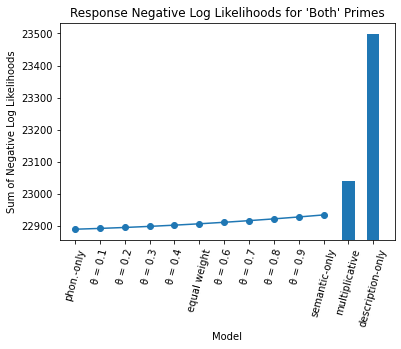

In [30]:
y = bothg['NLL']

values = ['phon.-only', 'θ = 0.1', 'θ = 0.2', 'θ = 0.3','θ = 0.4','equal weight', 'θ = 0.6', 'θ = 0.7', 'θ = 0.8', 'θ = 0.9', 'semantic-only', 'multiplicative', 'description-only'] 

plt.plot(x[:11],y[:1.0],marker="o")
plt.bar(x[11:],y[1.1:], width=.05)
plt.ylim(min(y)-35, max(y)+35)
plt.xlabel("Model")
plt.ylabel("Sum of Negative Log Likelihoods")
plt.title("Response Negative Log Likelihoods for 'Both' Primes")
plt.xticks(x,values, rotation=75)
plt.show()

In [27]:
delta(bothg, len(both)/13)

,NLL,k,BIC,deltaBIC
theta,,,,
0.0,22889.779791,4.0,45810.901899,5.042916
0.1,22892.301249,4.0,45815.944816,5.912070
0.2,22895.257284,4.0,45821.856885,6.778264
0.3,22898.646416,4.0,45828.635149,7.641528
0.4,22902.467180,4.0,45836.276677,8.501889
0.5,22906.718124,4.0,45844.778566,9.359377
0.6,22911.397813,4.0,45854.137943,10.214018
0.7,22916.504822,4.0,45864.351961,11.065840
0.8,22922.037742,4.0,45875.417802,11.914870


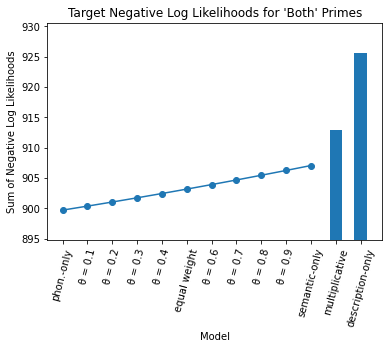

In [31]:
y = tbothg['NLL']

values = ['phon.-only', 'θ = 0.1', 'θ = 0.2', 'θ = 0.3','θ = 0.4','equal weight', 'θ = 0.6', 'θ = 0.7', 'θ = 0.8', 'θ = 0.9', 'semantic-only', 'multiplicative', 'description-only'] 

plt.plot(x[:11],y[:1.0],marker="o")
plt.bar(x[11:],y[1.1:], width=.05)
plt.ylim(min(y)-5, max(y)+5)
plt.xlabel("Model")
plt.ylabel("Sum of Negative Log Likelihoods")
plt.title("Target Negative Log Likelihoods for 'Both' Primes")
plt.xticks(x,values, rotation=75)
plt.show()

In [32]:
delta(tbothg, len(tboth)/13)

,NLL,k,BIC,deltaBIC
theta,,,,
0.0,899.720828,4.0,1817.862337,1.318401
0.1,900.380029,4.0,1819.180738,1.352598
0.2,901.056328,4.0,1820.533336,1.386684
0.3,901.749670,4.0,1821.920020,1.420658
0.4,902.459999,4.0,1823.340678,1.454522
0.5,903.187259,4.0,1824.795199,1.488277
0.6,903.931398,4.0,1826.283476,1.521924
0.7,904.692359,4.0,1827.805400,1.555464
0.8,905.470091,4.0,1829.360863,1.588898


## Neither

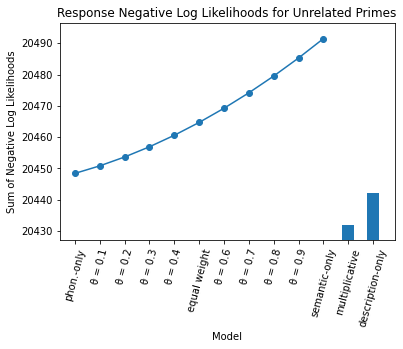

In [33]:
y = neitherg['NLL']

values = ['phon.-only', 'θ = 0.1', 'θ = 0.2', 'θ = 0.3','θ = 0.4','equal weight', 'θ = 0.6', 'θ = 0.7', 'θ = 0.8', 'θ = 0.9', 'semantic-only', 'multiplicative', 'description-only'] 

plt.plot(x[:11],y[:1.0],marker="o")
plt.bar(x[11:],y[1.1:], width=.05)
plt.ylim(min(y)-5, max(y)+5)
plt.xlabel("Model")
plt.ylabel("Sum of Negative Log Likelihoods")
plt.title("Response Negative Log Likelihoods for Unrelated Primes")
plt.xticks(x,values, rotation=75)
plt.show()

In [34]:
delta(neitherg, len(neither)/13)

,NLL,k,BIC,deltaBIC
theta,,,,
1.1,20431.992082,3.0,40887.074164,4.998183
1.2,20442.187840,1.0,40892.072347,35.544285
0.0,20448.414982,4.0,40927.616632,4.810410
0.1,20450.820187,4.0,40932.427042,5.665330
0.2,20453.652852,4.0,40938.092373,6.515965
0.3,20456.910835,4.0,40944.608338,7.362369
0.4,20460.592019,4.0,40951.970706,8.204594
0.5,20464.694316,4.0,40960.175300,9.042692
0.6,20469.215662,4.0,40969.217993,9.876713


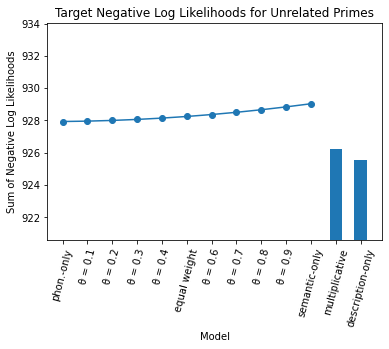

In [35]:
y = tneitherg['NLL']

values = ['phon.-only', 'θ = 0.1', 'θ = 0.2', 'θ = 0.3','θ = 0.4','equal weight', 'θ = 0.6', 'θ = 0.7', 'θ = 0.8', 'θ = 0.9', 'semantic-only', 'multiplicative', 'description-only'] 

plt.plot(x[:11],y[:1.0],marker="o")
plt.bar(x[11:],y[1.1:], width=.05)
plt.ylim(min(y)-5, max(y)+5)
plt.xlabel("Model")
plt.ylabel("Sum of Negative Log Likelihoods")
plt.title("Target Negative Log Likelihoods for Unrelated Primes")
plt.xticks(x,values, rotation=75)
plt.show()

In [36]:
delta(tneitherg, len(tneither)/13)

,NLL,k,BIC,deltaBIC
theta,,,,
1.2,925.568153,1.0,1855.741475,10.539257
1.1,926.232611,3.0,1866.280732,8.011876
0.0,927.935963,4.0,1874.292608,0.047455
0.1,927.959691,4.0,1874.340062,0.086369
0.2,928.002875,4.0,1874.426431,0.125090
0.3,928.065420,4.0,1874.551521,0.163620
0.4,928.147230,4.0,1874.715141,0.201962
0.5,928.248211,4.0,1874.917103,0.240118
0.6,928.368270,4.0,1875.157221,0.278091


# Age

In [57]:
# repeating above processes filtering by age, prime duration
old = newd[newd['AgeGroup']=='Old']
young = newd[newd['AgeGroup']=='Young']
print(len(old))
print(len(young))

42172
85865


In [59]:
oldg = old[['theta', 'NLL']].groupby(['theta']).sum()
youngg = young[['theta', 'NLL']].groupby(['theta']).sum()

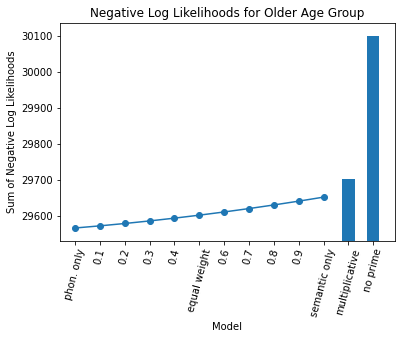

In [60]:
x = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2]
y = oldg['NLL']

values = ['phon. only', '0.1', '0.2', '0.3','0.4','equal weight', '0.6', '0.7', '0.8', '0.9', 'semantic only', 'multiplicative', 'no prime'] 

plt.plot(x[:11],y[:1.0],marker="o")
plt.bar(x[11:],y[1.1:], width=.05)
plt.ylim(min(y)-35, max(y)+35)
plt.xlabel("Model")
plt.ylabel("Sum of Negative Log Likelihoods")
plt.title("Negative Log Likelihoods for Older Age Group")
plt.xticks(x,values, rotation=75)
plt.show()

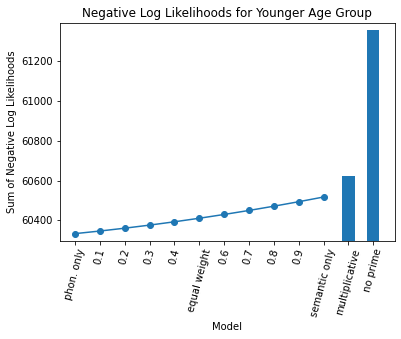

In [61]:
x = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2]
y = youngg['NLL']

values = ['phon. only', '0.1', '0.2', '0.3','0.4','equal weight', '0.6', '0.7', '0.8', '0.9', 'semantic only', 'multiplicative', 'no prime'] 

plt.plot(x[:11],y[:1.0],marker="o")
plt.bar(x[11:],y[1.1:], width=.05)
plt.ylim(min(y)-35, max(y)+35)
plt.xlabel("Model")
plt.ylabel("Sum of Negative Log Likelihoods")
plt.title("Negative Log Likelihoods for Younger Age Group")
plt.xticks(x,values, rotation=75)
plt.show()

# Prime Duration

In [62]:
long300 = newd[(newd['ExperimentName']=='tot not the prime') | (newd['ExperimentName']=='tot extended prime')]
short48 = newd[newd['ExperimentName']=='tot 48 ms']
print(len(long300))
print(len(short48))

100945
27092


In [66]:
long300g = long300[['theta', 'NLL']].groupby(['theta']).sum()
short48g = short48[['theta', 'NLL']].groupby(['theta']).sum()

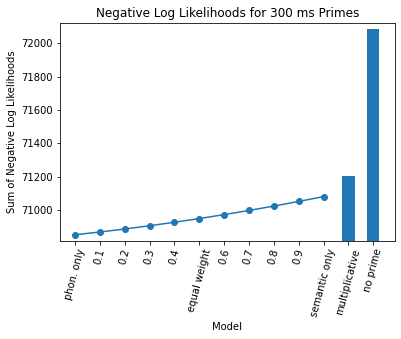

In [67]:
x = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2]
y = long300g['NLL']

values = ['phon. only', '0.1', '0.2', '0.3','0.4','equal weight', '0.6', '0.7', '0.8', '0.9', 'semantic only', 'multiplicative', 'no prime'] 

plt.plot(x[:11],y[:1.0],marker="o")
plt.bar(x[11:],y[1.1:], width=.05)
plt.ylim(min(y)-35, max(y)+35)
plt.xlabel("Model")
plt.ylabel("Sum of Negative Log Likelihoods")
plt.title("Negative Log Likelihoods for 300 ms Primes")
plt.xticks(x,values, rotation=75)
plt.show()

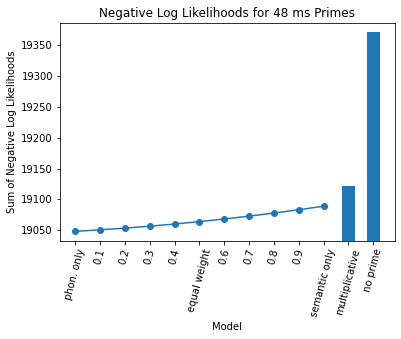

In [68]:
x = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2]
y = short48g['NLL']

values = ['phon. only', '0.1', '0.2', '0.3','0.4','equal weight', '0.6', '0.7', '0.8', '0.9', 'semantic only', 'multiplicative', 'no prime'] 

plt.plot(x[:11],y[:1.0],marker="o")
plt.bar(x[11:],y[1.1:], width=.05)
plt.ylim(min(y)-15, max(y)+15)
plt.xlabel("Model")
plt.ylabel("Sum of Negative Log Likelihoods")
plt.title("Negative Log Likelihoods for 48 ms Primes")
plt.xticks(x,values, rotation=75)
plt.show()

# Reported State

In [37]:
# filter by response to question about cognitive state
know = newd[newd['Question.RESP'] == 1]
dontknow = newd[newd['Question.RESP'] == 2]
otherword = newd[newd['Question.RESP'] == 3]
tot = newd[newd['Question.RESP'] == 4]
print(len(know))
print(len(dontknow))
print(len(otherword))
print(len(tot))

89479
3354
27716
7488


In [43]:
# group by model and sum negative log-likelihoods
knowg = know[['theta', 'NLL']].groupby(['theta']).sum()
dontknowg = dontknow[['theta', 'NLL']].groupby(['theta']).sum()
otherwordg = otherword[['theta', 'NLL']].groupby(['theta']).sum()
totg = tot[['theta', 'NLL']].groupby(['theta']).sum()

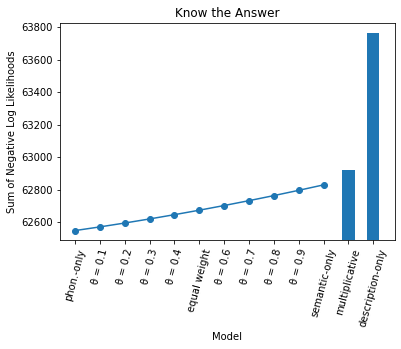

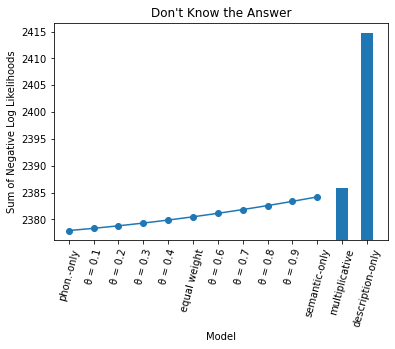

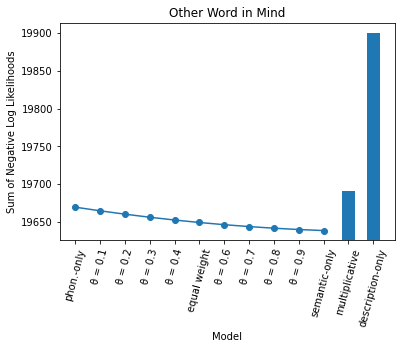

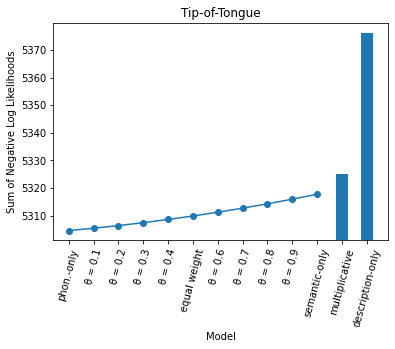

In [44]:
# plots for each state
states = {"Know the Answer": knowg, "Don't Know the Answer": dontknowg, "Other Word in Mind": otherwordg, "Tip-of-Tongue": totg}
for state in states.keys():
  y = states[state]['NLL']
  k = (max(y) - min(y)) / 20
  plt.plot(x[:11],y[:1.0],marker="o")
  plt.bar(x[11:],y[1.1:], width=.05)
  plt.ylim(min(y)-k, max(y)+k)
  plt.xlabel("Model")
  plt.ylabel("Sum of Negative Log Likelihoods")
  plt.title(state)
  plt.xticks(x,values, rotation=75)
  plt.show()

In [39]:
# results sorted from lowest (best) to highest
delta(knowg, len(know)/13)

,NLL,k,BIC,deltaBIC
theta,,,,
0.0,62547.763107,4.0,125130.873453,45.269567
0.1,62570.397890,4.0,125176.143020,47.745116
0.2,62594.270448,4.0,125223.888136,50.210540
0.3,62619.375718,4.0,125274.098675,52.665949
0.4,62645.708693,4.0,125326.764625,55.111452
0.5,62673.264419,4.0,125381.876077,57.547155
0.6,62702.037996,4.0,125439.423232,59.973159
0.7,62732.024576,4.0,125499.396391,62.389566
0.8,62763.219358,4.0,125561.785956,64.796474


In [40]:
delta(dontknowg, len(dontknow)/13)

,NLL,k,BIC,deltaBIC
theta,,,,
0.0,2377.909588,4.0,4778.031013,0.839042
0.1,2378.329108,4.0,4778.870055,0.932561
0.2,2378.795389,4.0,4779.802616,1.025689
0.3,2379.308233,4.0,4780.828305,1.118429
0.4,2379.867448,4.0,4781.946734,1.210787
0.5,2380.472841,4.0,4783.157521,1.302767
0.6,2381.124225,4.0,4784.460288,1.394374
0.7,2381.821412,4.0,4785.854662,1.485611
0.8,2382.564217,4.0,4787.340273,0.996898


In [41]:
delta(otherwordg, len(otherword)/13)

,NLL,k,BIC,deltaBIC
theta,,,,
1.0,19638.469038,4.0,39307.597338,2.760716
0.9,19639.849396,4.0,39310.358054,3.519632
0.8,19641.609212,4.0,39313.877687,4.281321
0.7,19643.749872,4.0,39318.159007,5.045812
0.6,19646.272778,4.0,39323.204819,5.813137
0.5,19649.179347,4.0,39329.017956,6.583331
0.4,19652.471012,4.0,39335.601287,7.356424
0.3,19656.149224,4.0,39342.957711,8.132453
0.2,19660.215450,4.0,39351.090164,8.911450


In [42]:
delta(totg, len(tot)/13)

,NLL,k,BIC,deltaBIC
theta,,,,
0.0,5304.594590,4.0,10634.613610,1.693575
0.1,5305.441377,4.0,10636.307185,1.903522
0.2,5306.393138,4.0,10638.210707,2.112652
0.3,5307.449464,4.0,10640.323359,2.320972
0.4,5308.609950,4.0,10642.644331,2.528492
0.5,5309.874196,4.0,10645.172823,2.735222
0.6,5311.241807,4.0,10647.908045,2.941169
0.7,5312.712392,4.0,10650.849214,3.146342
0.8,5314.285562,4.0,10653.995556,3.350749


In [5]:
len(julie_files[(julie_files['Resp'] == '12345')&(julie_files['Question.RESP'] == 1)])/len(julie_files[julie_files['Question.RESP'] == 1])

0.025884016973125885

In [7]:
len(julie_files[(julie_files['Resp'] == '12345')&(julie_files['Question.RESP'] == 2)])/len(julie_files[julie_files['Question.RESP'] == 2])

0.9565508021390374

In [8]:
len(julie_files[(julie_files['Resp'] == '12345')&(julie_files['Question.RESP'] == 3)])/len(julie_files[julie_files['Question.RESP'] == 3])

0.09063829787234043

In [9]:
len(julie_files[(julie_files['Resp'] == '12345')&(julie_files['Question.RESP'] == 4)])/len(julie_files[julie_files['Question.RESP'] == 4])

0.7099198396793587

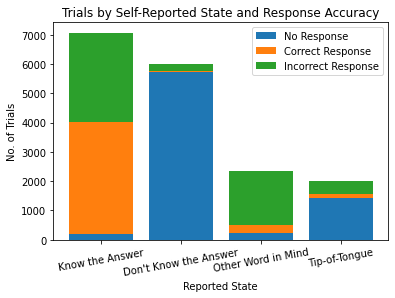

In [44]:
# plot the proportion of trials in each state that were incorrect, correct or didn't respond 
st = states.keys()

# count the number of no-responses, correct, and incorrect responses for each state 
noresp = [len(julie_files[(julie_files['Resp'] == '12345')&(julie_files['Question.RESP'] == s)]) for s in range(1,5)]
corr = [len(julie_files[(julie_files['NewAccuracy'] == 1)&(julie_files['Question.RESP'] == s)]) for s in range(1,5)]
incorr = [len(julie_files[(julie_files['Resp'] != '12345')&(julie_files['NewAccuracy'] == 0)&(julie_files['Question.RESP'] == s)]) for s in range(1,5)]


# plot a bar for each state and corresponding number, set the bottom of each category to the height of the previous one
plt.bar(st, noresp)
plt.bar(st, corr, bottom = np.array(noresp))
plt.bar(st, incorr, bottom = np.array(noresp) + np.array(corr))


plt.xlabel("Reported State")
plt.xticks(rotation = 10)
plt.ylabel("No. of Trials")
plt.title('Trials by Self-Reported State and Response Accuracy')
plt.legend(["No Response", "Correct Response", "Incorrect Response"])

plt.show()


## Know Responses

In [46]:
# of those who reported knowing the answer, filter correct and incorrect responses, group by model, and sum negative log-likelihoods
knowcorr = know[know['NewAccuracy']==1][['theta', 'NLL']].groupby(['theta']).sum()
knowincorr = know[know['NewAccuracy']==0][['theta', 'NLL']].groupby(['theta']).sum()

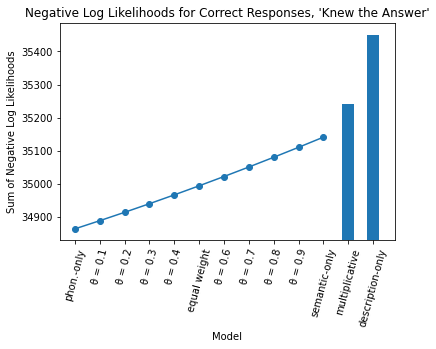

In [47]:
# plot each
y = knowcorr['NLL']

values = ['phon.-only', 'θ = 0.1', 'θ = 0.2', 'θ = 0.3','θ = 0.4','equal weight', 'θ = 0.6', 'θ = 0.7', 'θ = 0.8', 'θ = 0.9', 'semantic-only', 'multiplicative', 'description-only'] 

plt.plot(x[:11],y[:1.0],marker="o")
plt.bar(x[11:],y[1.1:], width=.05)
plt.ylim(min(y)-35, max(y)+35)
plt.xlabel("Model")
plt.ylabel("Sum of Negative Log Likelihoods")
plt.title("Negative Log Likelihoods for Correct Responses, 'Knew the Answer'")
plt.xticks(x,values, rotation=75)
plt.show()

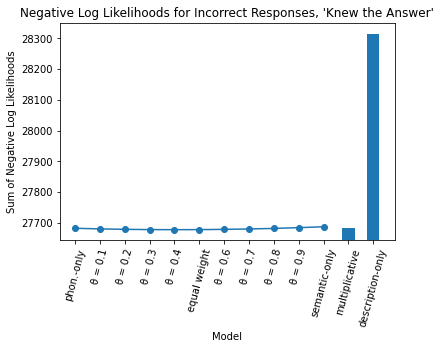

In [48]:
y = knowincorr['NLL']

values = ['phon.-only', 'θ = 0.1', 'θ = 0.2', 'θ = 0.3','θ = 0.4','equal weight', 'θ = 0.6', 'θ = 0.7', 'θ = 0.8', 'θ = 0.9', 'semantic-only', 'multiplicative', 'description-only'] 

plt.plot(x[:11],y[:1.0],marker="o")
plt.bar(x[11:],y[1.1:], width=.05)
plt.ylim(min(y)-35, max(y)+35)
plt.xlabel("Model")
plt.ylabel("Sum of Negative Log Likelihoods")
plt.title("Negative Log Likelihoods for Incorrect Responses, 'Knew the Answer'")
plt.xticks(x,values, rotation=75)
plt.show()

In [49]:
delta(knowcorr, len(know[know['NewAccuracy']==1])/13)

,NLL,k,BIC,deltaBIC
theta,,,,
0.0,34864.969495,4.0,69762.962304,49.210021
0.1,34889.574506,4.0,69812.172325,50.579563
0.2,34914.864288,4.0,69862.751889,51.943254
0.3,34940.835914,4.0,69914.695142,53.301152
0.4,34967.486490,4.0,69967.996294,54.653317
0.5,34994.813148,4.0,70022.649611,55.999805
0.6,35022.813051,4.0,70078.649416,57.340673
0.7,35051.483388,4.0,70135.990089,58.675975
0.8,35080.821375,4.0,70194.666063,60.005763


In [50]:
delta(knowincorr, len(know[know['NewAccuracy']==0])/13)

,NLL,k,BIC,deltaBIC
theta,,,,
0.4,27678.222202,4.0,55388.513635,0.458136
0.5,27678.451270,4.0,55388.971771,0.177067
0.3,27678.539804,4.0,55389.148837,0.649210
1.1,27682.873063,3.0,55389.798048,0.721072
0.6,27679.224945,4.0,55390.519120,0.362431
0.2,27679.406161,4.0,55390.881551,2.270055
0.7,27680.541188,4.0,55393.151606,0.564393
0.1,27680.823384,4.0,55393.715999,3.149199
0.8,27682.397984,4.0,55396.865197,0.791256


# No-Response

In [5]:
# filter out trials in which participant did not respond
noresp = julie_files[julie_files['Resp'] == '12345']
len(noresp)

7537

In [50]:
# group by prime condition
bycond = noresp.groupby('PrimeCondition')

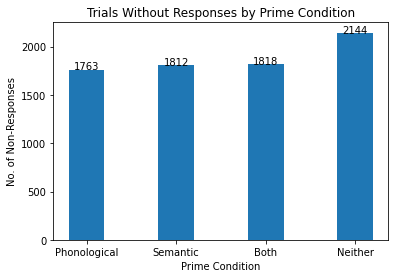

In [51]:
conds = ['Phonological', 'Semantic', 'Both', 'Neither']
counts = [len(bycond.get_group(x)) for x in ['P', 'R', 'B', 'U']] # count no. of non-responses in each condition
plt.bar(conds, counts, width = 0.4) # plot bar chart
for i in range(len(conds)):
  plt.text(i, counts[i], counts[i], ha = 'center') # superimpose text of numbers
plt.xlabel("Prime Condition")
plt.ylabel("No. of Non-Responses")
plt.title("Trials Without Responses by Prime Condition")
plt.show()

In [11]:
julie_files["NoResp"] = [1 if row['Resp']=='12345' else 0 for index, row in julie_files.iterrows()]
md = smf.mixedlm("NoResp ~ PrimeCondition",julie_files, groups=julie_files["Subject"], re_formula="~PrimeCondition")
mdf = md.fit(method=["lbfgs"])
print(mdf.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                         Mixed Linear Model Regression Results
Model:                       MixedLM           Dependent Variable:           NoResp     
No. Observations:            17400             Method:                       REML       
No. Groups:                  174               Scale:                        0.2073     
Min. group size:             100               Likelihood:                   -11343.7258
Max. group size:             100               Converged:                    Yes        
Mean group size:             100.0                                                      
----------------------------------------------------------------------------------------
                                              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------------------
Intercept                                      0.418    0.016 26.296 0.000  0.387  0.449
PrimeCondition[T.P]                           -

In [67]:
#REPLACE W MIXED EFFECTS MODEL
# code dummy variable for each condition in order to run ANOVA
p = [1 if row['PrimeCondition']=='P' else 0 for index, row in noresp.iterrows()]
r = [1 if row['PrimeCondition']=='R' else 0 for index, row in noresp.iterrows()]
b = [1 if row['PrimeCondition']=='B' else 0 for index, row in noresp.iterrows()]
u = [1 if row['PrimeCondition']=='U' else 0 for index, row in noresp.iterrows()]

In [69]:
stats.f_oneway(p, r, b, u) # one-way ANOVA


F_onewayResult(statistic=21.692495537129403, pvalue=4.9952712113365947e-14)

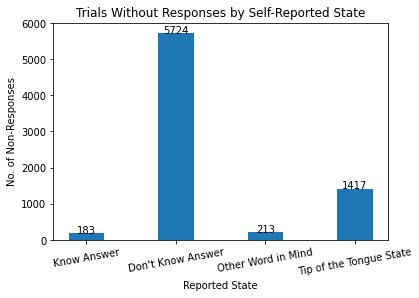

In [ ]:
# plot breaking down non-responses by self-reported state
st = ["Know Answer", "Don't Know Answer", "Other Word in Mind", "Tip of the Tongue State"]
y = [len(noresp[noresp["Question.RESP"] == x]) for x in range(1,5)] # count no. of trials with each state response
# plot bars and superimpose values
plt.bar(st, y, width = 0.4) 
plt.xticks(rotation = 10)
for i in range(len(st)):
  plt.text(i, y[i], y[i], ha = 'center') 
plt.xlabel("Reported State")
plt.ylabel("No. of Non-Responses")
plt.title("Trials Without Responses by Self-Reported State")
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key w

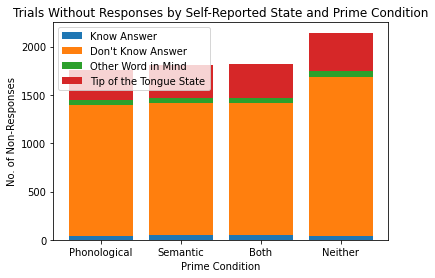

In [ ]:
# plot proportions of self-reported states for each prime condition
ka = [len(noresp[(noresp['Question.RESP'] == 1)&(julie_files['PrimeCondition'] == p)]) for p in ['P', 'R', 'B', 'U']]
dka = [len(noresp[(noresp['Question.RESP'] == 2)&(julie_files['PrimeCondition'] == p)]) for p in ['P', 'R', 'B', 'U']]
owim = [len(noresp[(noresp['Question.RESP'] == 3)&(julie_files['PrimeCondition'] == p)]) for p in ['P', 'R', 'B', 'U']]
tots = [len(noresp[(noresp['Question.RESP'] == 4)&(julie_files['PrimeCondition'] == p)]) for p in ['P', 'R', 'B', 'U']]

plt.bar(conds, np.array(ka))
plt.bar(conds, dka, bottom = np.array(ka))
plt.bar(conds, owim, bottom = np.array(ka) + np.array(dka))
plt.bar(conds, tots, bottom = np.array(ka) + np.array(dka) + np.array(owim))

plt.xlabel("Prime Condition")
plt.ylabel("No. of Non-Responses")
plt.title('Trials Without Responses by Self-Reported State and Prime Condition')
plt.legend(["Know Answer", "Don't Know Answer", "Other Word in Mind", "Tip of the Tongue State"])

plt.show()


# zRT vs. activation

In [ ]:

## first trim
rtdata = julie_files[(julie_files['FreeResp.RT']>200) & (julie_files['FreeResp.RT']<10000)]
## calculating mean and sd for each participant
subject_rt = rtdata.groupby('Subject', as_index=False).agg({'FreeResp.RT': ['mean', 'std']})


In [ ]:
len(julie_files)

17400

In [ ]:
len(rtdata)

16805

In [ ]:
(17400-16805)/17400

0.034195402298850576

In [ ]:
subject_rt.columns = subject_rt.columns.droplevel()
subject_rt.rename(columns={'':'Subject'}, inplace=True)

In [ ]:
rtdata

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,StudyNo,AgeGroup,PrimeInstruction,ExperimentName,Subject,Procedure,Trial,Both,Neither,Phonological,Semantic,Prime,PrimeCondition,Question.RESP,State.RT,FreeResp,Resp,FreeResp.RT,NewAccuracy,Accuracy,FreeRespPrimeIntrusion,Target,MCCorrect,McResp,McAcc,McRT,a,b,c,d,e,McActualResp,WhichPrime,ToEliminate,prompt,both_prompt,neither_prompt,sem_prompt,phon_prompt,prime_prompt,target_prompt,resp_prompt,target_both,target_neither,target_sem,target_phon,target_prime,target_resp,lev_target_both,lev_target_neither,lev_target_sem,lev_target_phon,lev_target_prime,lev_target_resp
0,0,0,0,6,Old,NotThePrime,tot not the prime,701,ExpProc1,1,avoid,dove,absolve,refuse,ABSOLVE,P,2,0,0,12345,1527,0,0,0,abstain,c,NaN,0,0,refuse,dove,abstain,absolve,avoid,0,X,0,To refrain deliberately and often with an effo...,0.066920,-0.033121,0.171530,0.127612,0.127612,0.125816,NaN,0.312840,0.089485,0.464569,0.217932,0.217932,NaN,0.166667,0.000000,0.000000,0.333333,0.333333,NaN
1,1,1,1,6,Old,NotThePrime,tot not the prime,701,ExpProc1,2,Norderstedt,image,neurosurgery,Berlin,NORDERSTEDT,B,2,6947,0,12345,1060,0,0,0,Nuremberg,d,d,1,7385,Norderstedt,Berlin,image,Nuremberg,neurosurgery,Nuremberg,0,0,German city for which antisemitic laws were na...,0.020833,-0.096533,0.164941,0.021730,0.020833,0.225719,NaN,0.180054,0.007681,0.428896,0.328091,0.180054,NaN,0.142857,0.125000,0.000000,0.333333,0.142857,NaN
3,3,3,3,6,Old,NotThePrime,tot not the prime,701,ExpProc1,4,Saigon,thigh,sofa,Tokyo,THIGH,U,1,4833,seoul,Seoul,3272,1,1,0,Seoul,b,b,1,4168,sofa,Seoul,Saigon,thigh,Tokyo,Seoul,0,0,Capital of South Korea,0.270083,0.000034,0.378604,0.100953,0.000034,0.609253,0.609253,0.424191,0.144735,0.464015,0.166060,0.144735,1.000000,0.200000,0.000000,0.200000,0.500000,0.000000,1.000000
4,4,4,4,6,Old,NotThePrime,tot not the prime,701,ExpProc1,5,Heinola,shop,handkerchief,Oslo,OSLO,R,1,7553,helsinki,Helsinki,3497,1,1,0,Helsinki,d,d,1,3366,Heinola,Oslo,shop,Helsinki,handkerchief,Helsinki,0,0,Capital of Finland,0.034701,-0.015010,0.383043,-0.002959,0.383043,0.575294,0.575294,0.222391,0.110593,0.546045,0.080330,0.546045,1.000000,0.125000,0.000000,0.125000,0.125000,0.125000,1.000000
5,5,5,5,6,Old,NotThePrime,tot not the prime,701,ExpProc1,6,twitch,weak,tip,jerk,WEAK,U,1,4089,tic,tic,1724,1,1,0,tic,a,a,1,2134,tic,tip,jerk,twitch,weak,tic,0,0,A habitual spastic motion of particular muscle...,0.159844,0.056092,0.229959,-0.034716,0.056092,0.025288,0.025288,0.295169,0.120406,0.111691,0.185589,0.120406,1.000000,0.500000,0.333333,0.333333,0.666667,0.333333,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17395,17395,17395,17395,1,Young,NoInstruction,tot 48 ms,44,ExpProc4,96,twitch,weak,tip,jerk,twitch,B,3,4551,twitch{SPACE},twitch,2451,0,0,NaN,tic,a,d,0,1303,tic,tip,jerk,twitch,weak,twitch,B,0,A habitual spastic motion of particular muscle...,0.159844,0.056092,0.229959,-0.034716,0.159844,0.025288,0.159844,0.295169,0.120406,0.111691,0.185589,0.295169,0.295169,0.500000,0.333333,0.333333,0.666667,0.500000,0.500000
17396,17396,17396,17396,1,Young,NoInstruction,tot 48 ms,44,ExpProc4,97,typhoon,grow,turmeric,hurricane,typhoon,B,1,1708,tsunami{SPACE},tsunami,2945,1,1,NaN,tsunami,a,a,1,1237,tsunami,turmeric,hurricane,typhoon,grow,tsunami,0,0,The proper name for a tidal\twave,0.069265,0.083020,0.028776,0.027943,0.069265,0.022911,0.022911,0.541872,0.193197,0.469321,0.051463,0.541872,1.000000,0.142857,0.000000,0.000000,0.100000,0.142857,1.000000
17397,17397,17397,17397,1,Young,NoInstruction,tot 48 ms,44,ExpProc4,98,Wilson,ball,wattage,Doyle,Wilson,B,1,5276,{SHIFT}Wagner{SPACE},Wagner,2528,0,0,NaN,Watson,a,a,1,3346,Watson,wattage,Doyle,Wilson,ball,Watson,0,0,Last name of Sherlock Holmes' assistant and fr...,0.158221,0.101450,0.342255,-0.037300,0.158221,0.350901,0.116549,0.406117,0.3318

In [ ]:
subject_rt

,Subject,mean,std
0,9,1301.250000,1260.968822
1,10,1870.323232,1461.617805
2,11,2642.500000,2362.031622
3,12,2510.640000,1887.217312
4,13,2313.560000,1799.150862
...,...,...,...
169,730,540.450000,528.861544
170,731,2153.958333,2504.696817
171,732,2364.280000,1426.621290
172,733,1606.520000,1830.524634


In [ ]:
## filtering above/below 3sd and zscoring
rtdata = rtdata.merge(subject_rt, on='Subject', how='left')
print(len(rtdata))
rtdata['zRT1'] = (rtdata['FreeResp.RT'] - rtdata['mean'])/rtdata['std']
rtdata = rtdata[(rtdata['zRT1']> -3) & (rtdata['zRT1']< 3)]
print(len(rtdata))

subject_rt1 = rtdata.groupby('Subject', as_index=False).agg({'FreeResp.RT': ['mean', 'std']})
subject_rt1.columns = subject_rt1.columns.droplevel()
subject_rt1.rename(columns={'':'Subject', 'mean': 'mean1', 'std': 'std1'}, inplace=True)
rtdata = rtdata.merge(subject_rt1, on='Subject', how='left')

rtdata['zRT'] = (rtdata['FreeResp.RT'] - rtdata['mean1'])/rtdata['std1']
print(len(rtdata))


16805
16471
16471


In [ ]:
(1527 - 2255.20202)/2466.733683	

-0.29520901466524474

In [ ]:
rtdata

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,StudyNo,AgeGroup,PrimeInstruction,ExperimentName,Subject,Procedure,Trial,Both,Neither,Phonological,Semantic,Prime,PrimeCondition,Question.RESP,State.RT,FreeResp,Resp,FreeResp.RT,NewAccuracy,Accuracy,FreeRespPrimeIntrusion,Target,MCCorrect,McResp,McAcc,McRT,a,b,c,d,e,McActualResp,WhichPrime,ToEliminate,prompt,both_prompt,neither_prompt,sem_prompt,phon_prompt,prime_prompt,target_prompt,resp_prompt,target_both,target_neither,target_sem,target_phon,target_prime,target_resp,lev_target_both,lev_target_neither,lev_target_sem,lev_target_phon,lev_target_prime,lev_target_resp,mean,std,zRT1,mean1,std1,zRT
0,0,0,0,6,Old,NotThePrime,tot not the prime,701,ExpProc1,1,avoid,dove,absolve,refuse,ABSOLVE,P,2,0,0,12345,1527,0,0,0,abstain,c,NaN,0,0,refuse,dove,abstain,absolve,avoid,0,X,0,To refrain deliberately and often with an effo...,0.066920,-0.033121,0.171530,0.127612,0.127612,0.125816,NaN,0.312840,0.089485,0.464569,0.217932,0.217932,NaN,0.166667,0.000000,0.000000,0.333333,0.333333,NaN,1991.333333,1986.283648,-0.233770,1787.053763,1650.275526,-0.157582
1,1,1,1,6,Old,NotThePrime,tot not the prime,701,ExpProc1,2,Norderstedt,image,neurosurgery,Berlin,NORDERSTEDT,B,2,6947,0,12345,1060,0,0,0,Nuremberg,d,d,1,7385,Norderstedt,Berlin,image,Nuremberg,neurosurgery,Nuremberg,0,0,German city for which antisemitic laws were na...,0.020833,-0.096533,0.164941,0.021730,0.020833,0.225719,NaN,0.180054,0.007681,0.428896,0.328091,0.180054,NaN,0.142857,0.125000,0.000000,0.333333,0.142857,NaN,1991.333333,1986.283648,-0.468882,1787.053763,1650.275526,-0.440565
2,3,3,3,6,Old,NotThePrime,tot not the prime,701,ExpProc1,4,Saigon,thigh,sofa,Tokyo,THIGH,U,1,4833,seoul,Seoul,3272,1,1,0,Seoul,b,b,1,4168,sofa,Seoul,Saigon,thigh,Tokyo,Seoul,0,0,Capital of South Korea,0.270083,0.000034,0.378604,0.100953,0.000034,0.609253,0.609253,0.424191,0.144735,0.464015,0.166060,0.144735,1.000000,0.200000,0.000000,0.200000,0.500000,0.000000,1.000000,1991.333333,1986.283648,0.644755,1787.053763,1650.275526,0.899817
3,4,4,4,6,Old,NotThePrime,tot not the prime,701,ExpProc1,5,Heinola,shop,handkerchief,Oslo,OSLO,R,1,7553,helsinki,Helsinki,3497,1,1,0,Helsinki,d,d,1,3366,Heinola,Oslo,shop,Helsinki,handkerchief,Helsinki,0,0,Capital of Finland,0.034701,-0.015010,0.383043,-0.002959,0.383043,0.575294,0.575294,0.222391,0.110593,0.546045,0.080330,0.546045,1.000000,0.125000,0.000000,0.125000,0.125000,0.125000,1.000000,1991.333333,1986.283648,0.758032,1787.053763,1650.275526,1.036158
4,5,5,5,6,Old,NotThePrime,tot not the prime,701,ExpProc1,6,twitch,weak,tip,jerk,WEAK,U,1,4089,tic,tic,1724,1,1,0,tic,a,a,1,2134,tic,tip,jerk,twitch,weak,tic,0,0,A habitual spastic motion of particular muscle...,0.159844,0.056092,0.229959,-0.034716,0.056092,0.025288,0.025288,0.295169,0.120406,0.111691,0.185589,0.120406,1.000000,0.500000,0.333333,0.333333,0.666667,0.333333,1.000000,1991.333333,1986.283648,-0.134590,1787.053763,1650.275526,-0.038208
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16466,17395,17395,17395,1,Young,NoInstruction,tot 48 ms,44,ExpProc4,96,twitch,weak,tip,jerk,twitch,B,3,4551,twitch{SPACE},twitch,2451,0,0,NaN,tic,a,d,0,1303,tic,tip,jerk,twitch,weak,twitch,B,0,A habitual spastic motion of particular muscle...,0.159844,0.056092,0.229959,-0.034716,0.159844,0.025288,0.159844,0.295169,0.120406,0.111691,0.185589,0.295169,0.295169,0.500000,0.333333,0.333333,0.666667,0.500000,0.500000,3248.606061,1914.015369,-0.416719,3189.234694,1829.932734,-0.403422
16467,17396,17396,17396,1,Young,NoInstruction,tot 48 ms,44,ExpProc4,97,typhoon,grow,turmeric,hurricane,typhoon,B,1,1708,tsunami{SPACE},tsunami,2945,1,1,NaN,tsunami,a,a,1,1237,tsunami,turmeric,hurricane,typhoon,grow,tsunami,0,0,The proper name for a tidal\twave,0.069265,0.083020,0.028776,0.027943,0.069265,0.022911,0.022

In [ ]:
## checking
subject_rt = rtdata.groupby('Subject').agg({'zRT': ['mean', 'std']})



In [ ]:
subject_rt

zRT     
                 mean  std
Subject                   
9        2.832202e-17  1.0
10      -3.820006e-17  1.0
11      -1.262148e-16  1.0
12      -1.076580e-16  1.0
13      -1.063964e-16  1.0
...               ...  ...
730      5.264975e-17  1.0
731      3.861645e-17  1.0
732      2.242875e-18  1.0
733     -6.797284e-18  1.0
735      8.621945e-17  1.0

[174 rows x 2 columns]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9c1ca04050>]],
      dtype=object)

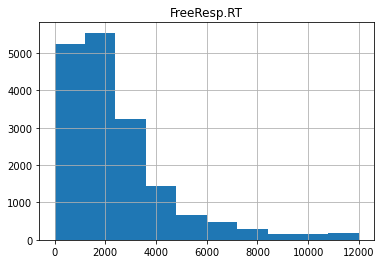

In [ ]:
julie_files.hist(column = 'FreeResp.RT')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9c1cafa390>,
      dtype=object)

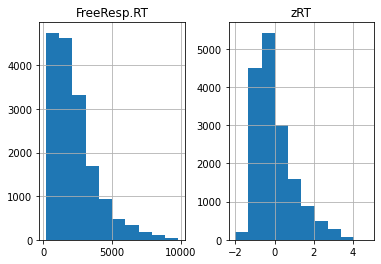

In [ ]:
rtdata.hist(column=['FreeResp.RT', 'zRT'])

In [ ]:
# TODO: 
# - merge zRT column with response likelihood 
# - group by theta 
# - for each group, plot zRT vs. likelihood in a different color
# - superimpose linear regression lines for each 
# - save a table with theta, r-value, R^2 and p-value 
# ----------




In [ ]:
respLLdf = pd.read_csv("/content/drive/My Drive/LexicalRetrieval-2021/ResponseLogLikelihoods.csv")

In [ ]:
respLLdf.drop(columns='Unnamed: 0', inplace=True)
respLLdf.rename(columns = {'resp':'Resp', 'prime': 'ActualPrime'}, inplace=True)
rtdata['ActualPrime'] = np.where(rtdata['PrimeCondition'] == 'P', rtdata['Phonological'], 
                                      np.where(rtdata['PrimeCondition'] == 'B', rtdata['Both'], 
                                               np.where(rtdata['PrimeCondition'] == 'R', rtdata['Semantic'],rtdata['Neither']))) 
rtdata['prompt'] = rtdata['prompt'].str.replace('\t',' ')                                      
rtdata['prompt'] = rtdata['prompt'].str.strip()
RTactmerge = rtdata.merge(respLLdf[['prompt', 'ActualPrime', 'Resp','theta', 'likelihood']])

In [ ]:
RTactmerge.head(20)

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,StudyNo,AgeGroup,PrimeInstruction,ExperimentName,Subject,Procedure,Trial,Both,Neither,Phonological,Semantic,Prime,PrimeCondition,Question.RESP,State.RT,FreeResp,Resp,FreeResp.RT,NewAccuracy,Accuracy,FreeRespPrimeIntrusion,Target,MCCorrect,McResp,McAcc,McRT,a,b,c,d,e,McActualResp,WhichPrime,ToEliminate,prompt,both_prompt,neither_prompt,sem_prompt,phon_prompt,prime_prompt,target_prompt,resp_prompt,target_both,target_neither,target_sem,target_phon,target_prime,target_resp,lev_target_both,lev_target_neither,lev_target_sem,lev_target_phon,lev_target_prime,lev_target_resp,ActualPrime,mean,std,zRT1,mean1,std1,zRT,theta,likelihood
0,3,3,3,6,Old,NotThePrime,tot not the prime,701,ExpProc1,4,Saigon,thigh,sofa,Tokyo,THIGH,U,1,4833,seoul,Seoul,3272,1,1,0,Seoul,b,b,1,4168,sofa,Seoul,Saigon,thigh,Tokyo,Seoul,0,0,Capital of South Korea,0.270083,0.000034,0.378604,0.100953,0.000034,0.609253,0.609253,0.424191,0.144735,0.464015,0.16606,0.144735,1.0,0.2,0.0,0.2,0.5,0.0,1.0,thigh,1991.333333,1986.283648,0.644755,1787.053763,1650.275526,0.899817,0.0,0.000124
1,3,3,3,6,Old,NotThePrime,tot not the prime,701,ExpProc1,4,Saigon,thigh,sofa,Tokyo,THIGH,U,1,4833,seoul,Seoul,3272,1,1,0,Seoul,b,b,1,4168,sofa,Seoul,Saigon,thigh,Tokyo,Seoul,0,0,Capital of South Korea,0.270083,0.000034,0.378604,0.100953,0.000034,0.609253,0.609253,0.424191,0.144735,0.464015,0.16606,0.144735,1.0,0.2,0.0,0.2,0.5,0.0,1.0,thigh,1991.333333,1986.283648,0.644755,1787.053763,1650.275526,0.899817,0.1,0.000125
2,3,3,3,6,Old,NotThePrime,tot not the prime,701,ExpProc1,4,Saigon,thigh,sofa,Tokyo,THIGH,U,1,4833,seoul,Seoul,3272,1,1,0,Seoul,b,b,1,4168,sofa,Seoul,Saigon,thigh,Tokyo,Seoul,0,0,Capital of South Korea,0.270083,0.000034,0.378604,0.100953,0.000034,0.609253,0.609253,0.424191,0.144735,0.464015,0.16606,0.144735,1.0,0.2,0.0,0.2,0.5,0.0,1.0,thigh,1991.333333,1986.283648,0.644755,1787.053763,1650.275526,0.899817,0.2,0.000125
3,3,3,3,6,Old,NotThePrime,tot not the prime,701,ExpProc1,4,Saigon,thigh,sofa,Tokyo,THIGH,U,1,4833,seoul,Seoul,3272,1,1,0,Seoul,b,b,1,4168,sofa,Seoul,Saigon,thigh,Tokyo,Seoul,0,0,Capital of South Korea,0.270083,0.000034,0.378604,0.100953,0.000034,0.609253,0.609253,0.424191,0.144735,0.464015,0.16606,0.144735,1.0,0.2,0.0,0.2,0.5,0.0,1.0,thigh,1991.333333,1986.283648,0.644755,1787.053763,1650.275526,0.899817,0.3,0.000125
4,3,3,3,6,Old,NotThePrime,tot not the prime,701,ExpProc1,4,Saigon,thigh,sofa,Tokyo,THIGH,U,1,4833,seoul,Seoul,3272,1,1,0,Seoul,b,b,1,4168,sofa,Seoul,Saigon,thigh,Tokyo,Seoul,0,0,Capital of South Korea,0.270083,0.000034,0.378604,0.100953,0.000034,0.609253,0.609253,0.424191,0.144735,0.464015,0.16606,0.144735,1.0,0.2,0.0,0.2,0.5,0.0,1.0,thigh,1991.333333,1986.283648,0.644755,1787.053763,1650.275526,0.899817,0.4,0.000126
5,3,3,3,6,Old,NotThePrime,tot not the prime,701,ExpProc1,4,Saigon,thigh,sofa,Tokyo,THIGH,U,1,4833,seoul,Seoul,3272,1,1,0,Seoul,b,b,1,4168,sofa,Seoul,Saigon,thigh,Tokyo,Seoul,0,0,Capital of South Korea,0.270083,0.000034,0.378604,0.100953,0.000034,0.609253,0.609253,0.424191,0.144735,0.464015,0.16606,0.144735,1.0,0.2,0.0,0.2,0.5,0.0,1.0,thigh,1991.333333,1986.283648,0.644755,1787.053763,1650.275526,0.899817,0.5,0.000126
6,3,3,3,6,Old,NotThePrime,tot not the prime,701,ExpProc1,4,Saigon,thigh,sofa,Tokyo,THIGH,U,1,4833,seoul,Seoul,3272,1,1,0,Seoul,b,b,1,4168,sofa,Seoul,Saigon,thigh,Tokyo,Seoul,0,0,Capital of South Korea,0.270083,0.000034,0.378604,0.100953,0.000034,0.609253,0.609253,0.424191,0.144735,0.464015,0.16606,0.144735,1.0,0.2,0.0,0.2,0.5,0.0,1.0,thigh,1991.333333,1986.283648,0.644755,1787.053763,1650.275526,0.899817,0.6,0.000126
7,3,3,3,6,Old,NotThePrime,tot not the prime,701,ExpProc1,4,Saigon,thigh,sofa,Tokyo,THIGH,U,1,4833,seoul,Seoul,3272,1,1,0,Seoul,b,b,1,4168,sofa,Seoul,Saigon,thigh,Tokyo,Seoul,0,0,Capital of South Korea,0.270083,0.000034,0.378604,0.100953,0.000034,0.609253,0.609253,0.424191,0.144735,0.464015,0.16606,0.144735,1.0,0.2,0.0,0.2,0.5,0.0,1.0,thigh,1991.333333,1986.283648,0.644755,1787.05

In [ ]:
RTactmerge.drop_duplicates(inplace=True)


In [ ]:
byT = RTactmerge[['theta', 'prompt', 'ActualPrime', 'Resp', 'Subject','zRT', 'likelihood']].groupby('theta')

In [ ]:
byT.get_group(1.1)

,theta,prompt,ActualPrime,Resp,Subject,zRT,likelihood
11,1.1,Capital of South Korea,thigh,Seoul,701,0.899817,0.000134
284,1.1,Capital of South Korea,thigh,Seoul,709,0.218779,0.000134
557,1.1,Capital of South Korea,thigh,Seoul,165,-0.366932,0.000134
830,1.1,Capital of South Korea,thigh,Seoul,169,-0.081982,0.000134
1103,1.1,Capital of South Korea,thigh,Seoul,173,2.388901,0.000134
...,...,...,...,...,...,...,...
1005587,1.1,To plead the cause of another; to support or p...,plank,advertise,44,0.373656,0.000086
1005600,1.1,Identical in form; coinciding exactly when sup...,cognizant,alike,44,-0.092481,0.000104
1005613,1.1,To raise into position by means of a pulley,dredge,dredge,44,0.152883,0.000207
1005626,1.1,A distinctive or peculiar feature or character...,uniqueness,nickname,44,-0.083191,0.000091


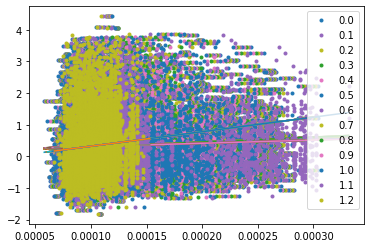

In [ ]:
# TODO: lin. regressions for each theta, add and mult
linregs = {}
x = np.linspace(byT['likelihood'].min(), byT['likelihood'].max(), 100)
for name, group in byT:
  linregs[name] = stats.linregress(group['likelihood'], group['zRT'])
  plt.plot(group['likelihood'], group['zRT'], marker=".", linestyle="", label=name)
  plt.plot(x, linregs[name].intercept + linregs[name].slope*x)
plt.legend()
plt.show()

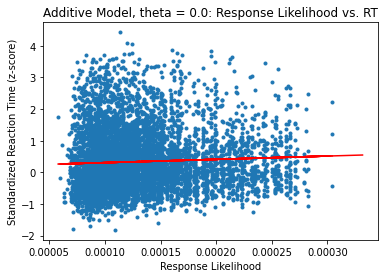

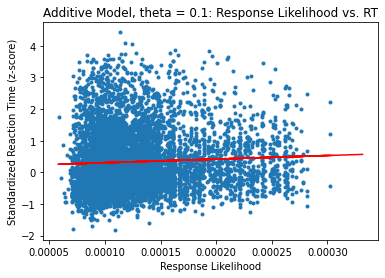

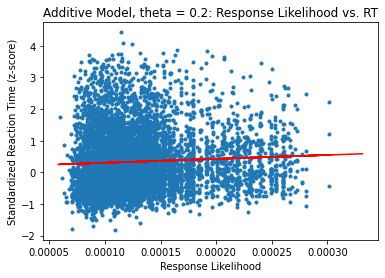

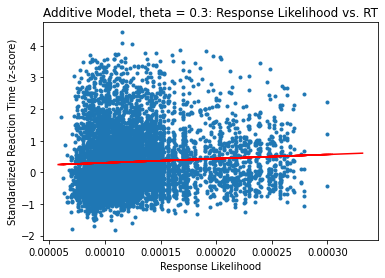

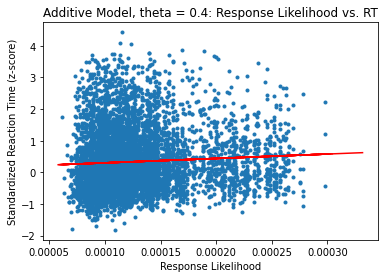

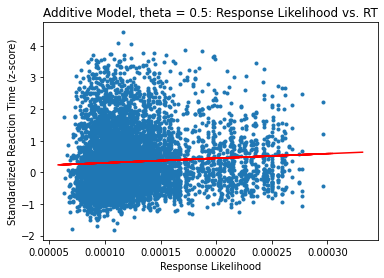

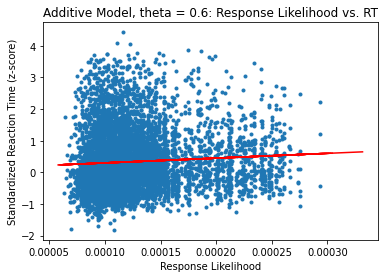

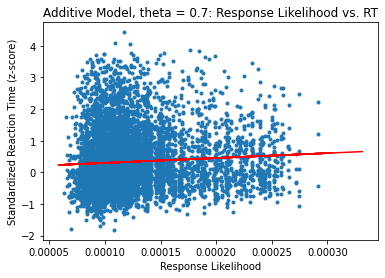

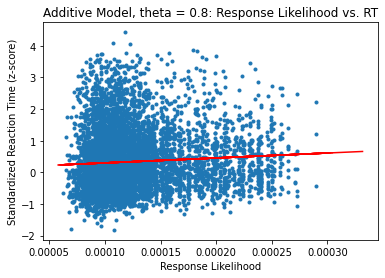

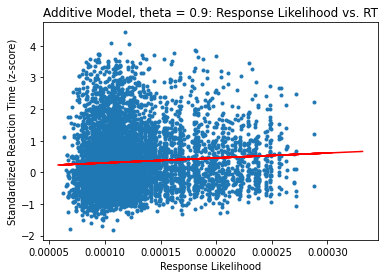

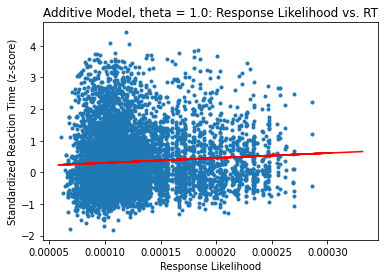

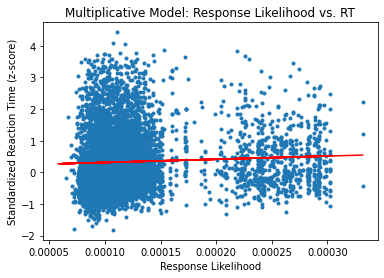

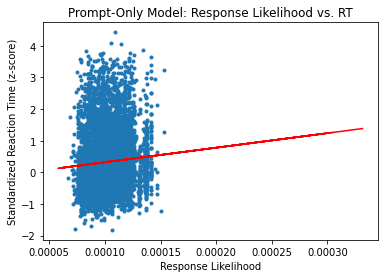

In [ ]:
for name, group in byT:
  linregs[name] = stats.linregress(group['likelihood'], group['zRT'])
  plt.plot(group['likelihood'], group['zRT'], marker=".", linestyle="", label=name)
  plt.plot(x, linregs[name].intercept + linregs[name].slope*x, "r")
  plt.xlabel('Response Likelihood')
  plt.ylabel('Standardized Reaction Time (z-score)')
  if name < 1.1:
    plt.title('Additive Model, theta = '+ str(name) + ': Response Likelihood vs. RT')
  if name == 1.1:
    plt.title('Multiplicative Model: Response Likelihood vs. RT')
  if name == 1.2:
    plt.title('Prompt-Only Model: Response Likelihood vs. RT')
  plt.show()

In [ ]:
linregtable = pd.DataFrame.from_dict(linregs, orient='index')

In [ ]:
linregtable['R-squared'] = linregtable['rvalue'] ** 2
linregtable

,slope,intercept,rvalue,pvalue,stderr,R-squared
0.0,1041.931691,0.200723,0.050153,2.269872e-05,245.775657,0.002515
0.1,1136.776141,0.189275,0.052960,7.679009e-06,253.900886,0.002805
0.2,1228.781769,0.178269,0.055592,2.644694e-06,261.418088,0.003090
0.3,1315.132409,0.168047,0.057998,9.570170e-07,268.143758,0.003364
0.4,1392.808768,0.158969,0.060127,3.766016e-07,273.894500,0.003615
0.5,1458.809395,0.151390,0.061928,1.668786e-07,278.499397,0.003835
0.6,1510.420731,0.145624,0.063359,8.599906e-08,281.813660,0.004014
0.7,1545.497414,0.141914,0.064388,5.292530e-08,283.731663,0.004146
0.8,1562.702023,0.140399,0.064996,3.959645e-08,284.197231,0.004224
0.9,1561.654862,0.141104,0.065178,3.627732e-08,283.209218,0.004248


In [ ]:
linregtable.index.rename('theta', inplace=True)

In [ ]:
linregtable

,slope,intercept,rvalue,pvalue,stderr,R-squared
theta,,,,,,
0.0,1041.931691,0.200723,0.050153,2.269872e-05,245.775657,0.002515
0.1,1136.776141,0.189275,0.052960,7.679009e-06,253.900886,0.002805
0.2,1228.781769,0.178269,0.055592,2.644694e-06,261.418088,0.003090
0.3,1315.132409,0.168047,0.057998,9.570170e-07,268.143758,0.003364
0.4,1392.808768,0.158969,0.060127,3.766016e-07,273.894500,0.003615
0.5,1458.809395,0.151390,0.061928,1.668786e-07,278.499397,0.003835
0.6,1510.420731,0.145624,0.063359,8.599906e-08,281.813660,0.004014
0.7,1545.497414,0.141914,0.064388,5.292530e-08,283.731663,0.004146
0.8,1562.702023,0.140399,0.064996,3.959645e-08,284.197231,0.004224


In [ ]:
linregtable.to_csv("/content/drive/My Drive/LexicalRetrieval-2021/zRTvsResponseLikelihoodRegressionOutput.csv")

In [ ]:
singlegrp = RTactmerge[(RTactmerge['PrimeInstruction'] == 'NotThePrime')&(RTactmerge['AgeGroup'] == 'Young')]

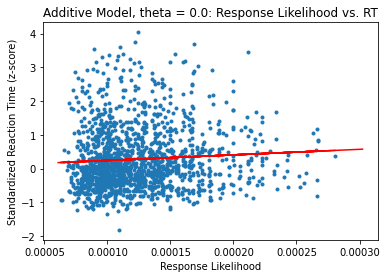

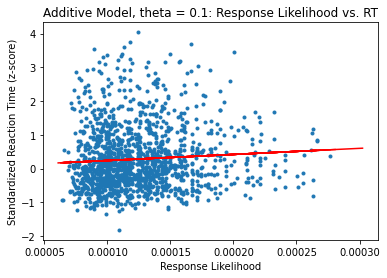

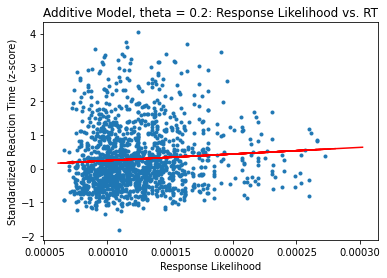

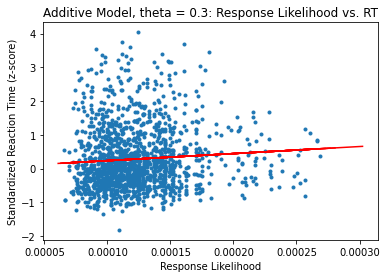

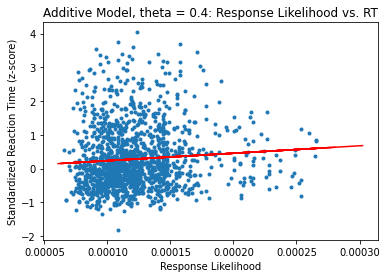

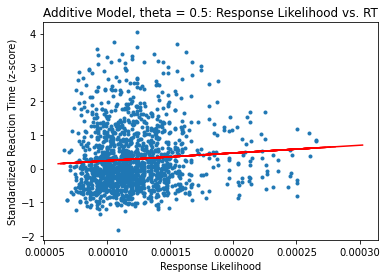

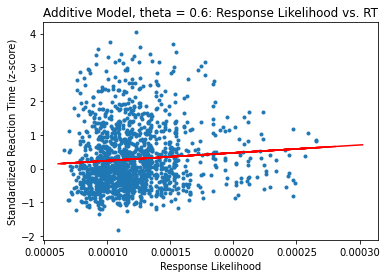

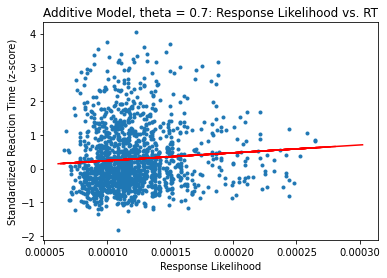

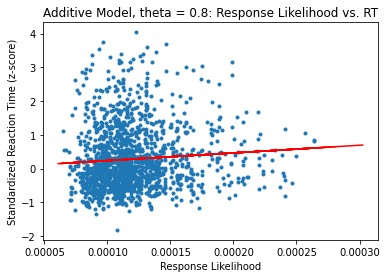

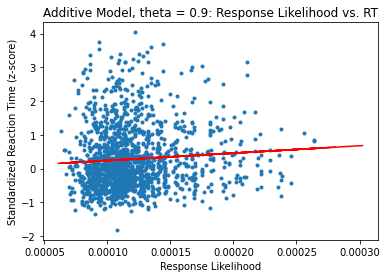

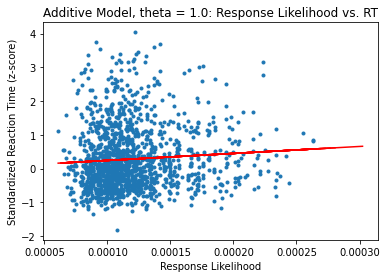

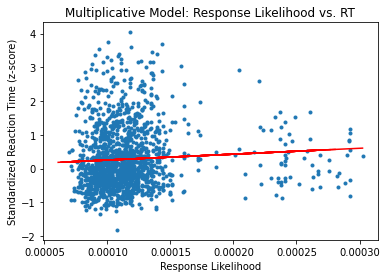

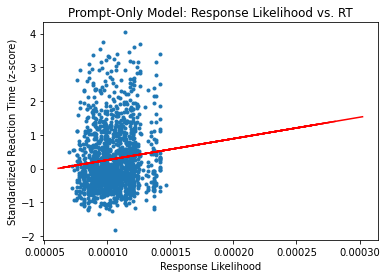

In [ ]:
byT1 = singlegrp[['theta', 'prompt', 'ActualPrime', 'Resp', 'Subject','zRT', 'likelihood']].groupby('theta')
linregs1 = {}
x = np.linspace(byT1['likelihood'].min(), byT1['likelihood'].max(), 100)
for name, group in byT1:
  linregs1[name] = stats.linregress(group['likelihood'], group['zRT'])
  plt.plot(group['likelihood'], group['zRT'], marker=".", linestyle="", label=name)
  plt.plot(x, linregs1[name].intercept + linregs1[name].slope*x, "r")
  plt.xlabel('Response Likelihood')
  plt.ylabel('Standardized Reaction Time (z-score)')
  if name < 1.1:
    plt.title('Additive Model, theta = '+ str(name) + ': Response Likelihood vs. RT')
  if name == 1.1:
    plt.title('Multiplicative Model: Response Likelihood vs. RT')
  if name == 1.2:
    plt.title('Prompt-Only Model: Response Likelihood vs. RT')
  plt.show()

In [ ]:
linregtable1 = pd.DataFrame.from_dict(linregs1, orient='index')
linregtable1['R-squared'] = linregtable1['rvalue'] ** 2
linregtable1.index.rename('theta', inplace=True)
linregtable1

,slope,intercept,rvalue,pvalue,stderr,R-squared
theta,,,,,,
0.0,1648.491664,0.074288,0.066254,0.009918,638.470678,0.004390
0.1,1805.331706,0.056164,0.069139,0.007119,669.910767,0.004780
0.2,1957.206122,0.038772,0.071772,0.005207,699.498772,0.005151
0.3,2095.439254,0.023138,0.074026,0.003952,725.972614,0.005480
0.4,2210.173484,0.010413,0.075772,0.003176,747.978143,0.005741
0.5,2291.720367,0.001711,0.076891,0.002755,764.229192,0.005912
0.6,2332.359665,-0.002102,0.077293,0.002617,773.705306,0.005974
0.7,2328.065648,-0.000604,0.076941,0.002738,775.836154,0.005920
0.8,2279.501717,0.006071,0.075853,0.003144,770.611507,0.005754


# Modeling Ideas

Some ways to think about how to "model" the task:


1. After obtaining the representation for the prompt and all words in the vocabulary, start an "activation" process such that at t = 0, activation "spreads" from the prompt to all words in proportion to their similarity to the prompt
2. At t=1, those words further spread activation to their neighbors.
3. This could continue for "t" time steps technically, but we can also introduce a prime at some time step. This "prime" gets some extra boost of activation (+5 units, say), and then similarities are assessed as a combination of prompt and cue to ultimately produce the response. 
4. Maybe the ideal way to do this is an "activation" matrix of size vocab x 1 for both semantic and phonology and then we merge the two eventually?
5. We may want to add in some stochastic noise to simulate partial knowledge in these models to see how that changes things
6. So a general process model might be:
*   activate_prompt_neighbors(noise) returns a 1-d array of similarities to every word in the vocab
*   activate_prime_neighbors(noise) returns two N-by-1 arrays of similarities+activation corresponding to semantic and phonological similarities
*   combine_semantic_phonological(method = "additive | multiplicative") returns a single N-by-1 array corresponding to combined sem-phon similarities after the promot and prime activations have been activated
*   generate_predictions() returns a softmax of the activated matrix
7. Ultimately, we want to make the code below efficient, and simulate about 100 participant runs with different levels of "noise" corresponding to levels of knowledge to obtain different model predictions
8. Also, we may want to have a parameter that controls the weight to semantic vs. phonological information in the "combine" function











# Old stuff

Completed with n 1
Completed with n 2
Completed with n 3
Completed with n 4
Completed with n 5
Completed with n 6
Completed with n 7
Completed with n 8
Completed with n 9
Completed with n 10
Completed with n 11
Completed with n 12
Completed with n 13
Completed with n 14
Completed with n 15
Completed with n 16
Completed with n 17
Completed with n 18
Completed with n 19
Completed with n 20


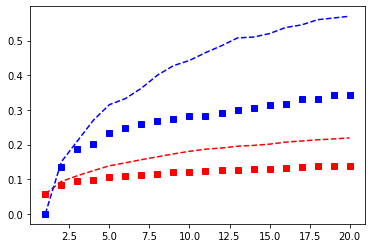

In [ ]:
# plot response and target accuracy together with varying n's, theta = .8
rAdd = []
rMult = []
tAdd = []
tMult = []
x = range(1,21)
for i in x:
  acc = accuracy_overall(vocab, i, 0.8)
  rAdd.append(acc[0])
  rMult.append(acc[1])
  tAdd.append(acc[2])
  tMult.append(acc[3])
  print("Completed with n", i)

plt.plot(x, rAdd, 'r--', x, rMult, 'rs', x, tAdd, 'b--', x, tMult, 'bs')

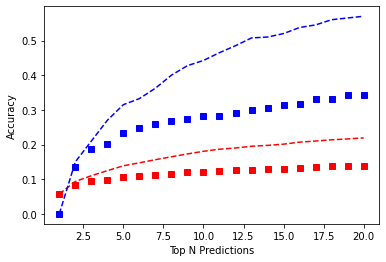

In [ ]:
plt.plot(x, rAdd, 'r--', x, rMult, 'rs', x, tAdd, 'b--', x, tMult, 'bs')
plt.xlabel("Top N Predictions")
plt.ylabel("Accuracy")
plt.show()

Accuracy of additive model: 0.07744531053557958
Accuracy of multiplicative model: 0.12195121951219512
Completed with alpha 0.0
Accuracy of additive model: 0.08901181795323108
Accuracy of multiplicative model: 0.12195121951219512
Completed with alpha 0.1
Accuracy of additive model: 0.09504651747548404
Accuracy of multiplicative model: 0.12195121951219512
Completed with alpha 0.2
Accuracy of additive model: 0.10611013326628112
Accuracy of multiplicative model: 0.12195121951219512
Completed with alpha 0.30000000000000004
Accuracy of additive model: 0.1249685692733216
Accuracy of multiplicative model: 0.12195121951219512
Completed with alpha 0.4
Accuracy of additive model: 0.14382700528036207
Accuracy of multiplicative model: 0.12195121951219512
Completed with alpha 0.5
Accuracy of additive model: 0.16117676640683934
Accuracy of multiplicative model: 0.12195121951219512
Completed with alpha 0.6000000000000001
Accuracy of additive model: 0.17374905707819965
Accuracy of multiplicative model:

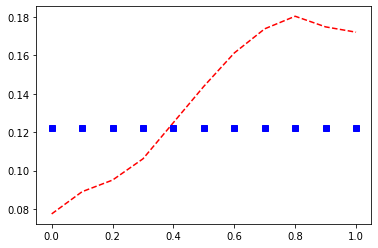

In [ ]:
# plot accuracy as a function of n or theta for both add and mult 
#nvals = [i for i in range(5, 11)] #change upper bound depending on value of topn used in generate_predictions()
#plt.plot(nvals, accuracy_overall(vocab, nvals)[0], 'r--', nvals, accuracy_overall(vocab, nvals)[1]) 
a = [x * 0.1 for x in range(11)]
yAdd = []
yMult = []
for i in a:
  acc = accuracy_overall(vocab, 10, i, resp_wide)
  yAdd.append(acc[0])
  yMult.append(acc[1])
  print("Completed with theta", i)

plt.plot(a, yAdd, 'r--', a, yMult, 'bs')
plt.show()

# Measure target accuracy


In [ ]:
targetacc_data

,ActualPrime,PrimeCondition,Target,prompt
0,absolve,P,abstain,To refrain deliberately and often with an effo...
1,Norderstedt,B,Nuremberg,German city for which antisemitic laws were named
2,hematoma,B,hemorrhage,"The escape of blood from vessels, including in..."
3,thigh,U,Seoul,Capital of South Korea
4,Oslo,R,Helsinki,Capital of Finland
...,...,...,...,...
395,terse,B,taciturn,"Saying little, reserved, uncommunicative"
396,bagel,U,chameleon,A small lizard with skin that changes color to...
397,Sardinia,B,Sicily,The largest Mediterranean island; the Italian ...
398,Shelley,B,Shaw,Last name of Irish author well known for Pygma...


In [ ]:
saved_prompt_acts = prompt_acts
saved_prime_acts = prime_acts

In [ ]:
# modify functions for targetacc_data
targ_add_success = []
targ_mult_success = []
def targ_acc_single(t, vocab_words, n, theta, data):
  prompt_neighbors = saved_prompt_acts[data["prompt"][t]]
  if data["ActualPrime"][t] not in saved_prime_acts:
    a, b = activate_prime_neighbors(prompt_neighbors, data["ActualPrime"][t])
    saved_prime_acts[data["ActualPrime"][t]] = (a, b)
  else:
    a, b = saved_prime_acts[data["ActualPrime"][t]]
  final_add = combine_semantic_phonological(a, b, "add", theta)
  final_mult = combine_semantic_phonological(a, b, "multiply")
  preds_add = generate_predictions(final_add, vocab_words, topn = 10)
  preds_mult = generate_predictions(final_mult, vocab_words, topn = 10)
  if data["Target"][t] in preds_add[:n]:
    targ_add_success.append(1)
  else:
    targ_add_success.append(0)
  if data["Target"][t] in preds_mult[:n]:
    targ_mult_success.append(1)
  else:
    targ_mult_success.append(0)

def targ_acc_overall(vocab_words, n, theta, data):
  # returns the overall probability that the target will appear in the top n words predicted by the model
  targ_add_success.clear()
  targ_mult_success.clear()
  for t in range(len(data.index)):
    targ_acc_single(t, vocab_words, n, theta, data)
  acc_add = np.mean(targ_add_success)
  acc_mult = np.mean(targ_mult_success)
  print("Accuracy of additive model:", acc_add)
  print("Accuracy of multiplicative model:", acc_mult)
  return acc_add, acc_mult

Accuracy of additive model: 0.0825
Accuracy of multiplicative model: 0.2825
Completed with alpha 0.0
Accuracy of additive model: 0.1375
Accuracy of multiplicative model: 0.2825
Completed with alpha 0.1
Accuracy of additive model: 0.1725
Accuracy of multiplicative model: 0.2825
Completed with alpha 0.2
Accuracy of additive model: 0.23
Accuracy of multiplicative model: 0.2825
Completed with alpha 0.30000000000000004
Accuracy of additive model: 0.2925
Accuracy of multiplicative model: 0.2825
Completed with alpha 0.4
Accuracy of additive model: 0.355
Accuracy of multiplicative model: 0.2825
Completed with alpha 0.5
Accuracy of additive model: 0.4075
Accuracy of multiplicative model: 0.2825
Completed with alpha 0.6000000000000001
Accuracy of additive model: 0.44
Accuracy of multiplicative model: 0.2825
Completed with alpha 0.7000000000000001
Accuracy of additive model: 0.4425
Accuracy of multiplicative model: 0.2825
Completed with alpha 0.8
Accuracy of additive model: 0.41
Accuracy of multi

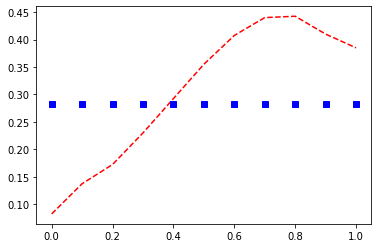

In [ ]:
targAdd = []
targMult = []
for i in a:
  acc = targ_acc_overall(vocab, 10, i, targetacc_data)
  targAdd.append(acc[0])
  targMult.append(acc[1])
  print("Completed with theta", i)

plt.plot(a, targAdd, 'r--', a, targMult, 'bs')
plt.show()

More plots

NameError: ignored

# model predictions: examples

In [ ]:
add, mult = lexical_retrieval_model("Capital of Finland", "Helsinki", vocab)
print("predictions for additive model:", add)
print("predictions for multiplicative model:", mult)

predictions for additive model: ['Helsinki', 'Finland', 'Czechoslovakia', 'Oslo', 'Nordic', 'Sweden', 'Berlin', 'Holland', 'Iceland', 'Celtic']
predictions for multiplicative model: ['Holland', 'Czechoslovakia', 'Berlin', 'Celtic', 'Helsinki', 'ski', 'Alpine', 'herring', 'Pilsen', 'clingy']


In [ ]:
add, mult = lexical_retrieval_model("A mathematical expression consisting of two terms", "bilateral", vocab)
print("predictions for additive model:", add)
print("predictions for multiplicative model:", mult)

predictions for additive model: ['biannual', 'bilateral', 'integral', 'mathematical', 'bisexual', 'partial', 'paternal', 'interval', 'binomial', 'mutual']
predictions for multiplicative model: ['bilateral', 'biannual', 'integral', 'binomial', 'paternal', 'interval', 'bisexual', 'partial', 'plural', 'mathematical']


In [ ]:
add, mult = lexical_retrieval_model("Identical in form; coinciding exactly when superimposed", "cognizant", vocab)
print("predictions for additive model:", add)
print("predictions for multiplicative model:", mult)

predictions for additive model: ['constant', 'cognition', 'cognizant', 'cognitive', 'confidant', 'confident', 'congruent', 'ignorant', 'coinciding', 'recognition']
predictions for multiplicative model: ['cognition', 'cognizant', 'cognitive', 'confident', 'confidant', 'constant', 'recognition', 'ignorant', 'coinciding', 'congruent']
